In [59]:
# подключаем библиотеки
from geopy.distance import geodesic as gd
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import datetime
import requests
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler


In [4]:
#задаем путь до файла
orders_data_path = r'C:\Users\PC\Desktop\diploma\Data\TumenData\TumenOrders.csv'

#загружаем данные в датафрейм
orders_data = pd.read_csv(orders_data_path,
                          dtype={'OrderId': 'uint32', 'EstimatedTimeArrival': 'int16', 'LoadArea': 'float32',
                                 'FeedPointLatitude': 'float32', 'FeedPointLongitude': 'float32',
                                 'TariffTypeId': 'uint32'},
                          parse_dates=['SetDriverDate', 'ArrivalDriverDate', 'OrderCreationDate'],
                          date_format="%Y-%m-%d %H:%M:%S.%f")

#выводим результат
display(orders_data)

,OrderId,EstimatedTimeArrival,SetDriverDate,ArrivalDriverDate,OrderCreationDate,LoadArea,FeedPointLatitude,FeedPointLongitude,TariffTTypeId
0,3546241840,2,2024-02-23 04:57:42.457,2024-02-23 04:57:50.783,2024-02-23 04:55:57.640,1.0,57.150726,65.534576,66
1,3548209178,3,2024-03-06 11:28:11.437,2024-03-06 11:28:42.560,2024-03-06 11:26:13.280,1.0,57.150726,65.534576,66
2,3545181356,10,2024-02-17 13:36:35.753,2024-02-17 13:45:52.593,2024-02-17 13:34:06.520,1.0,57.150612,65.540314,11
3,3544674788,23,2024-02-15 08:28:35.887,2024-02-15 08:52:51.310,2024-02-15 08:23:50.733,1.0,57.101444,65.592384,27
4,3544741846,4,2024-02-15 14:00:28.757,2024-02-15 14:02:38.143,2024-02-15 13:54:06.180,1.0,57.122231,65.526054,27
...,...,...,...,...,...,...,...,...,...
145643,3549307840,20,2024-03-12 13:11:00.257,2024-03-12 13:27:48.380,2024-03-12 13:10:20.693,1.0,57.101452,65.577003,1084
145644,3549335321,16,2024-03-12 16:35:31.980,2024-03-12 16:50:10.303,2024-03-12 16:34:24.670,1.0,57.204575,65.602242,1084
145645,3549440079,15,2024-03-13 12:20:30.407,2024-03-13 12:36:55.087,2024-03-13 12:09:17.090,1.0,57.110733,65.573792,1084
145646,3549478652,15,2024-03-13 17:39:13.897,2024-03-13 17:45:17.017,2024-03-13 16:59:03.620,1.0,57.115326,65.560928,1084


In [5]:
#задаем смещение времени относительно UTC
tumen_delta_time = datetime.timedelta(hours=5)

#применяем смещение к столбцу с временем создания заказа
orders_data['OrderCreationDate'] = orders_data['OrderCreationDate'] + tumen_delta_time

#выводим результат
display(orders_data)

,OrderId,EstimatedTimeArrival,SetDriverDate,ArrivalDriverDate,OrderCreationDate,LoadArea,FeedPointLatitude,FeedPointLongitude,TariffTTypeId
0,3546241840,2,2024-02-23 04:57:42.457,2024-02-23 04:57:50.783,2024-02-23 09:55:57.640,1.0,57.150726,65.534576,66
1,3548209178,3,2024-03-06 11:28:11.437,2024-03-06 11:28:42.560,2024-03-06 16:26:13.280,1.0,57.150726,65.534576,66
2,3545181356,10,2024-02-17 13:36:35.753,2024-02-17 13:45:52.593,2024-02-17 18:34:06.520,1.0,57.150612,65.540314,11
3,3544674788,23,2024-02-15 08:28:35.887,2024-02-15 08:52:51.310,2024-02-15 13:23:50.733,1.0,57.101444,65.592384,27
4,3544741846,4,2024-02-15 14:00:28.757,2024-02-15 14:02:38.143,2024-02-15 18:54:06.180,1.0,57.122231,65.526054,27
...,...,...,...,...,...,...,...,...,...
145643,3549307840,20,2024-03-12 13:11:00.257,2024-03-12 13:27:48.380,2024-03-12 18:10:20.693,1.0,57.101452,65.577003,1084
145644,3549335321,16,2024-03-12 16:35:31.980,2024-03-12 16:50:10.303,2024-03-12 21:34:24.670,1.0,57.204575,65.602242,1084
145645,3549440079,15,2024-03-13 12:20:30.407,2024-03-13 12:36:55.087,2024-03-13 17:09:17.090,1.0,57.110733,65.573792,1084
145646,3549478652,15,2024-03-13 17:39:13.897,2024-03-13 17:45:17.017,2024-03-13 21:59:03.620,1.0,57.115326,65.560928,1084


In [6]:
#задаем путь до файла
days_off_path = r'C:\Users\PC\Desktop\diploma\Data\TumenData\DaysOff2024.csv'

#загружаем данные в датафрейм
days_off = pd.read_csv(days_off_path, parse_dates=['Date'], date_format="%Y-%m-%d")

#оставляем только дату
days_off['Date'] = [date.date() for date in days_off['Date']]

#выводим результат
display(days_off)

,Date
0,2024-01-01
1,2024-01-02
2,2024-01-03
3,2024-01-04
4,2024-01-05
...,...
113,2024-12-21
114,2024-12-22
115,2024-12-29
116,2024-12-30


In [7]:
#формируем признак "был выходной день"
orders_data['IsWeekend'] = [1 if date_time.date() in days_off['Date'].values else 0 for date_time in
                            orders_data['OrderCreationDate']]

#выводим количество заказов, совершенных в выходной день
print('Количество заказов, совершенных в выходной день =',orders_data['IsWeekend'].sum())

Количество заказов, совершенных в выходной день = 51292


In [8]:
#задаем границы часов пик
rush_hour_time = [datetime.time(6, 0, 0), datetime.time(9, 0, 0), datetime.time(16, 0, 0), datetime.time(19, 0, 0)]

#задаем анонимную функцию, проверяющую выполнялся ли заказ в час пик
is_rush_hour = lambda time: rush_hour_time[0] <= time <= rush_hour_time[1] or rush_hour_time[2] <= time <= rush_hour_time[3]

#формируем признак "был час пик"
orders_data['IsRushHour'] = [1 if is_rush_hour(date_time.time()) else 0 for date_time in
                             orders_data['OrderCreationDate']]

#выводим количество заказов, совершенных в час пик
print('Количество заказов, совершенных в час пик =',orders_data['IsRushHour'].sum())

Количество заказов, совершенных в час пик = 43822


In [9]:
#создаем функцию для определения были ли осадки, принимаем на вход количество осадков
def check_has_precipitation(amount_precipitation):
    #пытаемся конвертировать количество осадков к float и проверить были ли осадки
    try:
        float_amount_precipitation = float(amount_precipitation)
        return float_amount_precipitation > 0
    #на вход может прийти текст, о том что осадков не было
    except ValueError:
        return False

In [10]:
#задаем путь до файла
weather_data_path = r'C:\Users\PC\Desktop\diploma\Data\TumenData\TumenWeather.csv'

#загружаем данные в датафрейм
weather_data = pd.read_csv(weather_data_path, parse_dates=['Date'], dayfirst=True, sep=';')

#формируем признак "были ли осадки"
weather_data['HasPrecipitation'] = weather_data['RRR'].apply(lambda x: int(check_has_precipitation(x)))

#оставляем только дату и признак
weather_data = weather_data[['Date', 'HasPrecipitation']]

#выводим результат
display(weather_data)

,Date,HasPrecipitation
0,2024-03-14 23:00:00,0
1,2024-03-14 20:00:00,1
2,2024-03-14 17:00:00,0
3,2024-03-14 14:00:00,0
4,2024-03-14 11:00:00,0
...,...,...
227,2024-02-15 14:00:00,0
228,2024-02-15 11:00:00,0
229,2024-02-15 08:00:00,0
230,2024-02-15 05:00:00,0


In [11]:
#объединяем заказы с погодой, получаем все сочетания
orders_with_weather_data = pd.merge(orders_data, weather_data, how='cross')

#вычисляем разницу во времени
orders_with_weather_data['DeltaTime'] = orders_with_weather_data['Date'] - orders_with_weather_data['OrderCreationDate']

#оставляем те варианты, где время создания заказа меньше временных отметок о погоде 
orders_with_weather_data = orders_with_weather_data[orders_with_weather_data['DeltaTime'] > datetime.timedelta(0)]

#сортируем, чтобы найти ближайшую отметку для заказа, группируем и берем первый элемент в каждой группе
orders_data = orders_with_weather_data.sort_values(by=['DeltaTime']).groupby('OrderId', as_index=False).first()

#выводим количество заказов совершенных в осадки
print('Количество заказов совершенных в осадки =',orders_data['HasPrecipitation'].sum())

Количество заказов совершенных в осадки = 4239


<Axes: xlabel='День недели', ylabel='Количество заказов'>

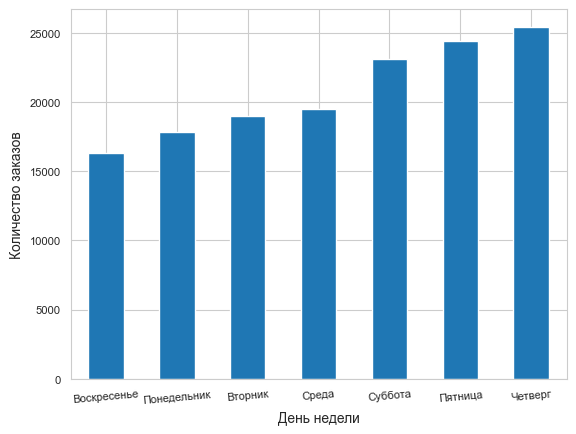

In [12]:
#задаем русские названия для дней недели
localized_day_of_week = ['Понедельник','Вторник','Среда','Четверг','Пятница','Суббота','Воскресенье']

#формируем признак день недели
orders_data['DayOfWeek'] = orders_data['OrderCreationDate'].apply(lambda creation_date: localized_day_of_week[creation_date.weekday()])

#выводим распределение заказов по дням недели(0 - понедельник)
orders_data[['OrderId','DayOfWeek']].groupby('DayOfWeek').count().sort_values(by = 'OrderId').plot(kind='bar', xlabel='День недели', ylabel='Количество заказов',legend=False, rot=5, fontsize=8)

In [13]:
#задаем путь до файла
tumen_drivers_path = r'C:\Users\PC\Desktop\diploma\Data\TumenData\TumenDrivers.csv'

#загружаем данные в датафрейм
tumen_drivers = pd.read_csv(tumen_drivers_path,
                            dtype={'driverid': 'uint32', 'driverlatitude': 'float32', 'driverlongitude': 'float32'},
                            parse_dates=['date'], date_format="%Y-%m-%d %H:%M:%S.%f")

#применяем смещение к столбцу с временем 
tumen_drivers['date'] = tumen_drivers['date'] + tumen_delta_time

#выводим результат
display(tumen_drivers)

,date,driverid,driverlatitude,driverlongitude
0,2024-02-28 10:12:19.875,3055334,57.147938,65.541496
1,2024-02-28 10:12:23.925,3055334,57.147942,65.541504
2,2024-02-28 10:13:20.542,3055334,57.147961,65.541451
3,2024-02-28 10:13:55.698,3055334,57.147953,65.541428
4,2024-02-28 10:14:56.750,3055334,57.148476,65.540443
...,...,...,...,...
37560034,2024-02-27 19:26:20.765,14160477,57.137123,65.539810
37560035,2024-02-27 19:26:55.718,14160477,57.137070,65.539818
37560036,2024-02-27 19:27:30.706,14160477,57.137058,65.539810
37560037,2024-02-27 19:28:05.718,14160477,57.137058,65.539810


In [14]:
#получаем всех уникальных водителей
tumen_unique_drivers = tumen_drivers['driverid'].drop_duplicates()

#выводим результат
display(tumen_unique_drivers)

0            3055334
187          3076862
243          3015408
511          3086835
513           309575
              ...   
37497369    14950055
37503201    14600199
37550655    11068178
37556391    14143057
37559597    14158826
Name: driverid, Length: 13555, dtype: uint32

In [15]:
#задаем путь до файла
drivers_with_auto_path = r'C:\Users\PC\Desktop\diploma\Data\TumenData\DriversWithAuto.csv'

#загружаем данные в датафрейм
drivers_with_auto = pd.read_csv(drivers_with_auto_path)

#выводим результат
display(drivers_with_auto)

,DriverId,AutoId
0,100016,11879094
1,100039,6805230
2,100056,3794953
3,100056,5566330
4,100056,16216391
...,...,...
4339950,15010577,16652667
4339951,15010591,5400362
4339952,15010591,16652692
4339953,15010594,16652691


In [16]:
#объединяем водителей с их автомобилями
tumen_drivers_with_auto = pd.merge(tumen_unique_drivers,
                                   drivers_with_auto, left_on=['driverid'], right_on=['DriverId'], how='left')

#удаляем некорректные данные 
tumen_drivers_with_auto = tumen_drivers_with_auto.dropna()

#выводим результат
display(tumen_drivers_with_auto)

,driverid,DriverId,AutoId
0,3055334,3055334.0,16651637.0
1,3076862,3076862.0,9416158.0
2,3015408,3015408.0,12707818.0
3,3015408,3015408.0,13183526.0
4,3086835,3086835.0,5495905.0
...,...,...,...
19054,14950055,14950055.0,16562931.0
19055,14600199,14600199.0,16075218.0
19056,11068178,11068178.0,12185497.0
19057,14143057,14143057.0,15446828.0


In [18]:
#задаем url для получения списка доступных тарифов для водителей
url = 'https://dev-drvtariff.taxsee.com/api/v1/tariffs/drivers/find-all'

#создаем список, который будем заполнять данными вида [driver_id, tariff_type_id]
available_drivers_tariffs = []

#идем по каждому водителю
for driver in tumen_drivers_with_auto.values:

    #получаем id водителя
    driverId = int(driver[0])

    #формируем тело запроса
    request = {
        "driverId": str(driverId),
        "autoId": str(int(driver[2])),
        "placeId": 3
    }

    #отправляем запрос
    response = requests.post(url, json=request)

    #формируем нужные данные
    for tariff in response.json()['tariffs']:
        available_drivers_tariffs.append([driverId, tariff['tariffTypeId']])

#оставляем уникальные значения, так как могут быть два автомобиля с пересекающимися тарифами 
available_drivers_tariffs = np.unique(available_drivers_tariffs, axis=0)
#выводим результат
display(available_drivers_tariffs)

array([[  100011,       27],
       [  100011,       43],
       [  100011,       67],
       ...,
       [14975464,     1429],
       [14975464,     1430],
       [14975464,     1475]])

In [19]:
#задаем путь до файла
drivers_info_path = r'C:\Users\PC\Desktop\diploma\Data\DriversInfoV2.csv'

#загружаем данные в датафрейм
drivers_info = pd.read_csv(drivers_info_path,
                           dtype={'DriverId': 'uint32', 'Rang': 'float32', 'CountCompleteAutoPlain': pd.Int32Dtype(),
                                  'CountCompleteOrders': pd.Int32Dtype(), 'CountFailureAutoPlain': pd.Int32Dtype()},
                           parse_dates=['UpdateRangDate'], date_format="%Y-%m-%d %H:%M:%S.%f")

#заменяем null на 0, так как для этого набора это идентичные значения
drivers_info = drivers_info.fillna(0)

#оставляем информацию только о водителях в Тюмени
drivers_info = drivers_info[drivers_info['DriverId'].isin(tumen_unique_drivers)]

#выводим результат
display(drivers_info)

,DriverId,Rang,CountCompleteAutoPlain,CountFailureAutoPlain,CountCompleteOrders,UpdateRangDate
26239,3684255,0.55,5,21,27,2015-10-28 05:14:44.193
41010,3831677,0.00,4,0,32,2015-10-28 12:22:20.363
44199,3851294,0.00,0,3,8,2015-10-28 13:13:18.377
57222,3852812,0.91,9,3,81,2015-11-18 21:43:17.737
80599,3749857,0.86,9,3,40,2015-12-30 21:53:21.070
...,...,...,...,...,...,...
9194826,10450403,0.98,8,0,27,2024-03-18 15:21:07.387
9194864,8209578,0.92,0,2,60,2024-03-18 15:21:08.013
9194892,14900787,0.97,0,0,37,2024-03-18 15:21:08.397
9194967,5277601,0.81,57,42,57,2024-03-18 15:26:09.123


In [20]:
#формируем из полученных данных датафрейм
available_drivers_tariffs_df = pd.DataFrame(available_drivers_tariffs, columns=['DriverId', 'TariffTypeId']) 

#сохраним полученный датафрейм
available_drivers_tariffs_df.to_csv("AvailableDriversTariffs", index=False)

In [21]:
#создаем функцию для расчета дистанции между водителем и точкой подачи
def calculate_distance(driver_coord, feed_point):
    return int(gd((driver_coord[2], driver_coord[3]),
                  (feed_point[6], feed_point[7])).meters)

In [22]:
#создаем функцию, которая отбирает водителей, для которых тип тарифа заказа совпадает с доступными ему типами тарифов
def get_suitable_drivers(drivers_ids, tariff_type_id):
    return [driver_id for driver_id in drivers_ids if
            tariff_type_id in drivers_with_available_tariffs.get(driver_id, [])]

In [23]:
#создаем функцию, которая вычисляет сколько прочих заказов находится рядом с искомым
def get_amount_orders_nearby(order):
    #находим разницу во времени между анализируемым и прочими заказами
    delta_time = (orders_data['OrderCreationDate'] - order[4]).dt.total_seconds()
    
    #задаем маску, разница между временем создания заказов должна быть не больше минуты, а также исключаем искомый заказ из прочих
    mask_delta_time_1m = delta_time.between(0, 60) & (orders_data['OrderId'] != order[0])
    
    #фильтруем заказы по заданной маске
    orders_within_2m = orders_data[mask_delta_time_1m].copy()
    
    #рассчитываем расстояние между заказами
    orders_within_2m['DistanceToOrder'] = [calculate_distance_between_order(order_within_2m, order) for order_within_2m
                                           in orders_within_2m.values]
    
    #фильтруем заказы по дистанции до анализируемого заказа
    orders_nearby_2km = orders_within_2m[orders_within_2m['DistanceToOrder'] < 2000]
    
    #возвращаем количество оставшихся заказов
    return orders_nearby_2km.shape[0]

In [24]:
#создаем функцию для вычисления вероятности отказа от заказа случайно выбранного водителя
def calculate_probability_refusal_order(drivers_ids, create_order_date):
    #если водителей нет, то считаем, что вероятность отказа равна 1
    if len(drivers_ids) == 0:
        return 1

    #оставляем статистическую информацию о нужных водителях
    drivers_info_fix_date = drivers_info[drivers_info['DriverId'].isin(drivers_ids)].copy()

    #находим разницу во времени, чтобы выбрать самые актуальные данные на момент создания заказа
    drivers_info_fix_date['DeltaUpdateDate'] = (create_order_date - drivers_info_fix_date['UpdateRangDate']).abs()

    #оставляем актуальные данные
    drivers_info_fix_date = drivers_info_fix_date.sort_values(by='DeltaUpdateDate').groupby(
        'DriverId').first().reset_index()

    #учитываем водителей, которые выполнили больше одного заказа
    drivers_info_fix_date = drivers_info_fix_date[
        (drivers_info_fix_date['CountCompleteAutoPlain'] > 0) | (drivers_info_fix_date['CountFailureAutoPlain'] > 0)]

    #вычисляем количество водителей
    count_drivers = drivers_info_fix_date.shape[0]

    #если водителей после фильтрации не осталось, считаем что вероятность отказа 0.5
    if count_drivers == 0:
        return 0.5

    #вычисляем вероятность отказа от заказа для каждого водителя
    probability = drivers_info_fix_date['CountFailureAutoPlain'] / (
                drivers_info_fix_date['CountFailureAutoPlain'] + drivers_info_fix_date['CountCompleteAutoPlain'])

    #вычисляем вероятность отказа случайно выбранного водителя
    return probability.sum() / count_drivers

In [25]:
#создаем функцию для расчета дистанции между заказами
def calculate_distance_between_order(first_order, second_order):
    return int(gd((first_order[6], first_order[7]),
                  (second_order[6], second_order[7])).meters)

In [26]:
#создаем функцию, в которой будут формироваться признаки для заказа
def process_order(order):
    #для удобства запишем время создания заказа в отдельную переменную
    creation_date = order[4]
    
    #находим разницу между временем создания заказа и записью о местоположении водителей
    delta_time = (tumen_drivers['date'] - creation_date).dt.total_seconds()
    
    #зададим маску, разница между датой создания заказа и записью о водителе не должна быть больше 15 секунд
    mask_delta_time_15s = delta_time.between(0, 15)
    
    #фильтруем записи о водителях по маске, а также удаляем дубликаты(в промежуток 15 секунд до и после создания заказа может попасть несколько записей о водителях)
    drivers_within_30s = tumen_drivers[mask_delta_time_15s].drop_duplicates(subset=['driverid'])

    #получаем идентификаторы подходящих водителей по типу тарифа
    suitable_drivers_within_30s = get_suitable_drivers(drivers_within_30s['driverid'].values, order[8])

    #фильтруем водителей по полученным идентификаторам с подходящими водителями 
    drivers_within_30s = drivers_within_30s[drivers_within_30s['driverid'].isin(suitable_drivers_within_30s)]

    #вычисляем расстояние между водителями и заказом
    drivers_within_30s['DistanceToOrder'] = [calculate_distance(driver, order) for driver in drivers_within_30s.values]

    #задаем маски для отбора водителей по расстоянию
    mask_order_less500m = drivers_within_30s['DistanceToOrder'] < 500
    mask_order_less1000m = (drivers_within_30s['DistanceToOrder'] >= 500) & (
            drivers_within_30s['DistanceToOrder'] < 1000)
    mask_order_less2000m = (drivers_within_30s['DistanceToOrder'] >= 1000) & (
            drivers_within_30s['DistanceToOrder'] < 2000)

    #фильтруем заказы по расстояниям
    drivers_radius_500m = drivers_within_30s[mask_order_less500m]
    drivers_radius_1000m = drivers_within_30s[mask_order_less1000m]
    drivers_radius_2000m = drivers_within_30s[mask_order_less2000m]

    #формируем признаки, связанные с количеством водителей в разных радиусах
    count_drivers_500m = len(drivers_radius_500m)
    count_drivers_1000m = len(drivers_radius_1000m)
    count_drivers_2000m = len(drivers_radius_2000m)

    #задаем дефолтные значения для расстояний до ближайших водителей
    distance_first_nearest_driver = 10000
    distance_second_nearest_driver = 10000
    distance_third_nearest_driver = 10000

    #задаем дефолтные значения для вероятностей отказа ближайших водителей от заказа
    probability_refusal_order_first_nearest_driver = 1
    probability_refusal_order_second_nearest_driver = 1
    probability_refusal_order_third_nearest_driver = 1

    #сортируем водителей по расстоянию до заказа
    sorted_drivers_within_30s = drivers_within_30s.sort_values(by='DistanceToOrder')

    #если водителей хватает заполняем переменные по всем водителям, иначе по тем, которые можем заполнить
    if sorted_drivers_within_30s.shape[0] >= 3:
        distance_first_nearest_driver = sorted_drivers_within_30s['DistanceToOrder'].iloc[0]
        distance_second_nearest_driver = sorted_drivers_within_30s['DistanceToOrder'].iloc[1]
        distance_third_nearest_driver = sorted_drivers_within_30s['DistanceToOrder'].iloc[2]
        probability_refusal_order_first_nearest_driver = calculate_probability_refusal_order(
            [sorted_drivers_within_30s['driverid'].iloc[0]], creation_date)
        probability_refusal_order_second_nearest_driver = calculate_probability_refusal_order(
            [sorted_drivers_within_30s['driverid'].iloc[1]], creation_date)
        probability_refusal_order_third_nearest_driver = calculate_probability_refusal_order(
            [sorted_drivers_within_30s['driverid'].iloc[2]], creation_date)
    elif sorted_drivers_within_30s.shape[0] == 2:
        distance_first_nearest_driver = sorted_drivers_within_30s['DistanceToOrder'].iloc[0]
        distance_second_nearest_driver = sorted_drivers_within_30s['DistanceToOrder'].iloc[1]
        probability_refusal_order_first_nearest_driver = calculate_probability_refusal_order(
            [sorted_drivers_within_30s['driverid'].iloc[0]], creation_date)
        probability_refusal_order_second_nearest_driver = calculate_probability_refusal_order(
            [sorted_drivers_within_30s['driverid'].iloc[1]], creation_date)
    elif sorted_drivers_within_30s.shape[0] == 1:
        distance_first_nearest_driver = sorted_drivers_within_30s['DistanceToOrder'].iloc[0]
        probability_refusal_order_first_nearest_driver = calculate_probability_refusal_order(
            [sorted_drivers_within_30s['driverid'].iloc[0]], creation_date)

    #вычисляем вероятности отказа от заказа водителей в заданных радиусах
    probability_refusal_order500m = calculate_probability_refusal_order(drivers_radius_500m['driverid'], creation_date)
    probability_refusal_order1000m = calculate_probability_refusal_order(drivers_radius_1000m['driverid'],
                                                                         creation_date)
    probability_refusal_order2000m = calculate_probability_refusal_order(drivers_radius_2000m['driverid'],
                                                                         creation_date)

    #вычисляем количество других заказов рядом с анализируемым
    orders_nearby_2km = get_amount_orders_nearby(order)

    #возвращаем полученные признаки
    return [count_drivers_500m, count_drivers_1000m, count_drivers_2000m, distance_first_nearest_driver,
            distance_second_nearest_driver, distance_third_nearest_driver,
            probability_refusal_order_first_nearest_driver, probability_refusal_order_second_nearest_driver,
            probability_refusal_order_third_nearest_driver, probability_refusal_order500m,
            probability_refusal_order1000m, probability_refusal_order2000m, orders_nearby_2km]


#получаем словарь, где ключ идентификатор водителя, а значение список доступных ему тарифов 
drivers_with_available_tariffs = available_drivers_tariffs_df.groupby('DriverId')['TariffTypeId'].apply(list).to_dict()

#запускаем формирование признаков для всех заказов параллельно
results = Parallel(n_jobs=6)(delayed(process_order)(order) for order in orders_data.values)

#формируем датафрейм из полученных признаков
sings_df = pd.DataFrame(results, columns=['CountDrivers500m', 'CountDrivers1000m', 'CountDrivers2000m',
                                          'DistanceToFirstNearestDriver', 'DistanceToSecondNearestDriver',
                                          'DistanceToThirdNearestDriver',
                                          'ProbabilityRefusalOrderFirstNearestDriver',
                                          'ProbabilityRefusalOrderSecondNearestDriver',
                                          'ProbabilityRefusalOrderThirdNearestDriver',
                                          'ProbabilityRefusalOrder500m', 'ProbabilityRefusalOrder1000m',
                                          'ProbabilityRefusalOrder2000m', 'CountOrdersAround'])

In [27]:
#объединяем информацию о заказах с полученными признаками
orders_data = pd.concat([orders_data, sings_df], axis=1, join='inner')

#выведем информацию об столбцах датафрейма для анализа
orders_data.describe()

,OrderId,EstimatedTimeArrival,SetDriverDate,ArrivalDriverDate,OrderCreationDate,LoadArea,FeedPointLatitude,FeedPointLongitude,TariffTTypeId,IsWeekend,...,DistanceToFirstNearestDriver,DistanceToSecondNearestDriver,DistanceToThirdNearestDriver,ProbabilityRefusalOrderFirstNearestDriver,ProbabilityRefusalOrderSecondNearestDriver,ProbabilityRefusalOrderThirdNearestDriver,ProbabilityRefusalOrder500m,ProbabilityRefusalOrder1000m,ProbabilityRefusalOrder2000m,CountOrdersAround
count,1.456480e+05,145648.000000,145648,145648,145648,145648.000000,145648.000000,145648.000000,145648.000000,145648.000000,...,1.456480e+05,1.456480e+05,1.456480e+05,145648.000000,145648.000000,145648.000000,145648.000000,145648.000000,145648.000000,145648.000000
mean,3.547036e+09,7.074302,2024-02-28 05:10:14.362316544,2024-02-28 05:15:50.621456384,2024-02-28 10:06:04.875046656,1.123619,57.139690,65.565132,1345.799077,0.352164,...,6.622500e+02,9.045356e+02,1.099605e+03,0.478186,0.480216,0.482713,0.607658,0.539397,0.500426,0.560948
min,3.544585e+09,2.000000,2024-02-15 00:01:58.203000,2024-02-15 00:03:33.630000,2024-02-15 05:00:25.540000,1.000000,0.000000,0.000000,11.000000,0.000000,...,0.000000e+00,5.000000e+00,1.100000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.545783e+09,5.000000,2024-02-20 20:28:09.800499968,2024-02-20 20:34:35.254249984,2024-02-21 01:24:00.197000192,1.000000,57.115910,65.538261,1448.000000,0.000000,...,1.680000e+02,3.400000e+02,4.760000e+02,0.250000,0.252747,0.264706,0.372093,0.346710,0.391983,0.000000
50%,3.547051e+09,6.000000,2024-02-28 00:07:33.329999872,2024-02-28 00:13:52.178499840,2024-02-28 05:02:47.367000064,1.000000,57.139355,65.570244,1448.000000,0.000000,...,3.060000e+02,5.090000e+02,6.660000e+02,0.500000,0.500000,0.500000,0.549675,0.500000,0.496372,0.000000
75%,3.548290e+09,8.000000,2024-03-07 02:23:16.877250048,2024-03-07 02:28:21.809750016,2024-03-07 07:17:32.307000064,1.250000,57.162884,65.596474,1448.000000,1.000000,...,5.020000e+02,7.560000e+02,9.610000e+02,0.630137,0.636364,0.642857,1.000000,0.734694,0.593131,1.000000
max,3.549500e+09,1040.000000,2024-03-14 02:29:45.407000,2024-03-14 02:32:32.207000,2024-03-14 04:59:51.620000,1.500000,57.393246,66.065170,1475.000000,1.000000,...,8.550994e+06,8.552179e+06,8.552207e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000
std,1.443397e+06,5.111376,NaN,NaN,NaN,0.134850,0.301082,0.348316,355.557138,0.477646,...,4.480175e+04,4.480647e+04,4.480917e+04,0.300514,0.300222,0.299762,0.334121,0.286367,0.196155,0.852690


In [28]:
#выведем информацию о типах столбцов, необходимо проверить, что они корректные
orders_data.dtypes

OrderId                                                uint32
EstimatedTimeArrival                                    int16
SetDriverDate                                  datetime64[ns]
ArrivalDriverDate                              datetime64[ns]
OrderCreationDate                              datetime64[ns]
LoadArea                                              float32
FeedPointLatitude                                     float32
FeedPointLongitude                                    float32
TariffTTypeId                                           int64
IsWeekend                                               int64
IsRushHour                                              int64
Date                                           datetime64[ns]
HasPrecipitation                                        int64
DeltaTime                                     timedelta64[ns]
DayOfWeek                                              object
CountDrivers500m                                        int64
CountDri

In [30]:
#переименуем столбцы для понятного отображения на графиках
orders_data_with_russian_naming = orders_data.rename(columns = {'EstimatedTimeArrival':'Расчетное время подачи', 'LoadArea':'Нагрузка на район', 'FeedPointLatitude': 'Широта точки подачи', 'FeedPointLongitude': 'Долгота точки подачи', 'TariffTTypeId': 'Идентификатор типа тарифа', 'IsWeekend': 'Выходной день', 'IsRushHour': 'Час пик', 'HasPrecipitation': 'Осадки', 'CountDrivers500m': 'Количество водителей в радиусе 500м', 'CountDrivers1000m': 'Количество водителей в радиусе 1000м', 'CountDrivers2000m': 'Количество водителей в радиусе 2000м', 'DistanceToFirstNearestDriver': 'Расстояние до первого ближайшего водителя', 'DistanceToSecondNearestDriver': 'Расстояние до второго ближайшего водителя', 'DistanceToThirdNearestDriver': 'Расстояние до третьего ближайшего водителя', 'ProbabilityRefusalOrderFirstNearestDriver': 'Вероятность отказа от заказа первого ближайшего водителя', 'ProbabilityRefusalOrderSecondNearestDriver': 'Вероятность отказа от заказа второго ближайшего водителя', 'ProbabilityRefusalOrderThirdNearestDriver': 'Вероятность отказа от заказа третьего ближайшего водителя', 'ProbabilityRefusalOrder500m': 'Вероятность отказа от заказа водителя в радиусе 500м', 'ProbabilityRefusalOrder1000m': 'Вероятность отказа от заказа водителя в радиусе 1000м', 'ProbabilityRefusalOrder2000m': 'Вероятность отказа от заказа водителя в радиусе 2000м', 'CountOrdersAround': 'Количество заказов вокруг', 'DayOfWeek': 'День недели'})

In [31]:
#эти столбцы имеют аномальные значения
orders_data_with_russian_naming[['Расчетное время подачи', 'Количество водителей в радиусе 500м',
                                 'Расстояние до первого ближайшего водителя']].describe()

,Расчетное время подачи,Количество водителей в радиусе 500м,Расстояние до первого ближайшего водителя
count,145648.000000,145648.000000,1.456480e+05
mean,7.074302,1.807241,6.622500e+02
std,5.111376,1.708419,4.480175e+04
min,2.000000,0.000000,0.000000e+00
25%,5.000000,0.000000,1.680000e+02
50%,6.000000,1.000000,3.060000e+02
75%,8.000000,3.000000,5.020000e+02
max,1040.000000,19.000000,8.550994e+06


In [32]:
#рассчитываем z-оценку для столбцов с аномальными значениями
z = stats.zscore(orders_data_with_russian_naming[['Расчетное время подачи', 'Расстояние до первого ближайшего водителя', 'Расстояние до второго ближайшего водителя', 'Расстояние до третьего ближайшего водителя']])

#задаем маску, все столбцы должны отклоняться меньше, чем на три СКО
z_mask = (np.abs(z) < 3).all(axis = 1)

# применим маску к столбцу
dataset = orders_data_with_russian_naming[z_mask]

#выведем описание столбцов, аномальные значения были удалены
dataset.describe()

,OrderId,Расчетное время подачи,SetDriverDate,ArrivalDriverDate,OrderCreationDate,Нагрузка на район,Широта точки подачи,Долгота точки подачи,Идентификатор типа тарифа,Выходной день,...,Расстояние до первого ближайшего водителя,Расстояние до второго ближайшего водителя,Расстояние до третьего ближайшего водителя,Вероятность отказа от заказа первого ближайшего водителя,Вероятность отказа от заказа второго ближайшего водителя,Вероятность отказа от заказа третьего ближайшего водителя,Вероятность отказа от заказа водителя в радиусе 500м,Вероятность отказа от заказа водителя в радиусе 1000м,Вероятность отказа от заказа водителя в радиусе 2000м,Количество заказов вокруг
count,1.438870e+05,143887.000000,143887,143887,143887,143887.000000,143887.000000,143887.000000,143887.000000,143887.000000,...,143887.000000,143887.000000,143887.000000,143887.000000,143887.000000,143887.000000,143887.000000,143887.000000,143887.000000,143887.000000
mean,3.547035e+09,6.770410,2024-02-28 05:00:07.278875904,2024-02-28 05:05:28.792719104,2024-02-28 09:56:00.372013568,1.124325,57.141098,65.567131,1350.363000,0.352596,...,411.514348,648.898580,840.960747,0.478163,0.480503,0.482838,0.605759,0.537226,0.498975,0.563665
min,3.544585e+09,2.000000,2024-02-15 00:01:58.203000,2024-02-15 00:03:33.630000,2024-02-15 05:00:25.540000,1.000000,56.878437,65.074898,11.000000,0.000000,...,0.000000,5.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.545779e+09,5.000000,2024-02-20 19:00:59.768000,2024-02-20 19:05:53.246499840,2024-02-20 23:59:18.166499840,1.000000,57.115856,65.538727,1448.000000,0.000000,...,167.000000,339.000000,475.000000,0.250000,0.253521,0.265060,0.369565,0.345416,0.391767,0.000000
50%,3.547046e+09,6.000000,2024-02-27 20:31:48.569999872,2024-02-27 20:36:50.800000,2024-02-28 01:26:29.503000064,1.000000,57.139091,65.570320,1448.000000,0.000000,...,304.000000,507.000000,663.000000,0.500000,0.500000,0.500000,0.545455,0.500000,0.495606,0.000000
75%,3.548290e+09,8.000000,2024-03-07 02:23:05.163500032,2024-03-07 02:28:03.129999872,2024-03-07 07:17:20.203000064,1.250000,57.162380,65.596397,1448.000000,1.000000,...,498.000000,750.000000,953.000000,0.632353,0.636364,0.644444,1.000000,0.728571,0.591667,1.000000
max,3.549500e+09,22.000000,2024-03-14 02:29:45.407000,2024-03-14 02:32:32.207000,2024-03-14 04:59:51.620000,1.500000,57.384636,66.065170,1475.000000,1.000000,...,29302.000000,31167.000000,31226.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000
std,1.443758e+06,3.190758,NaN,NaN,NaN,0.134908,0.030917,0.056216,348.884089,0.477780,...,530.424078,680.479152,790.659599,0.300588,0.300272,0.299740,0.333759,0.285253,0.193966,0.853903


<Axes: xlabel='Время подачи автомобиля, мин', ylabel='Количество заказов, шт'>

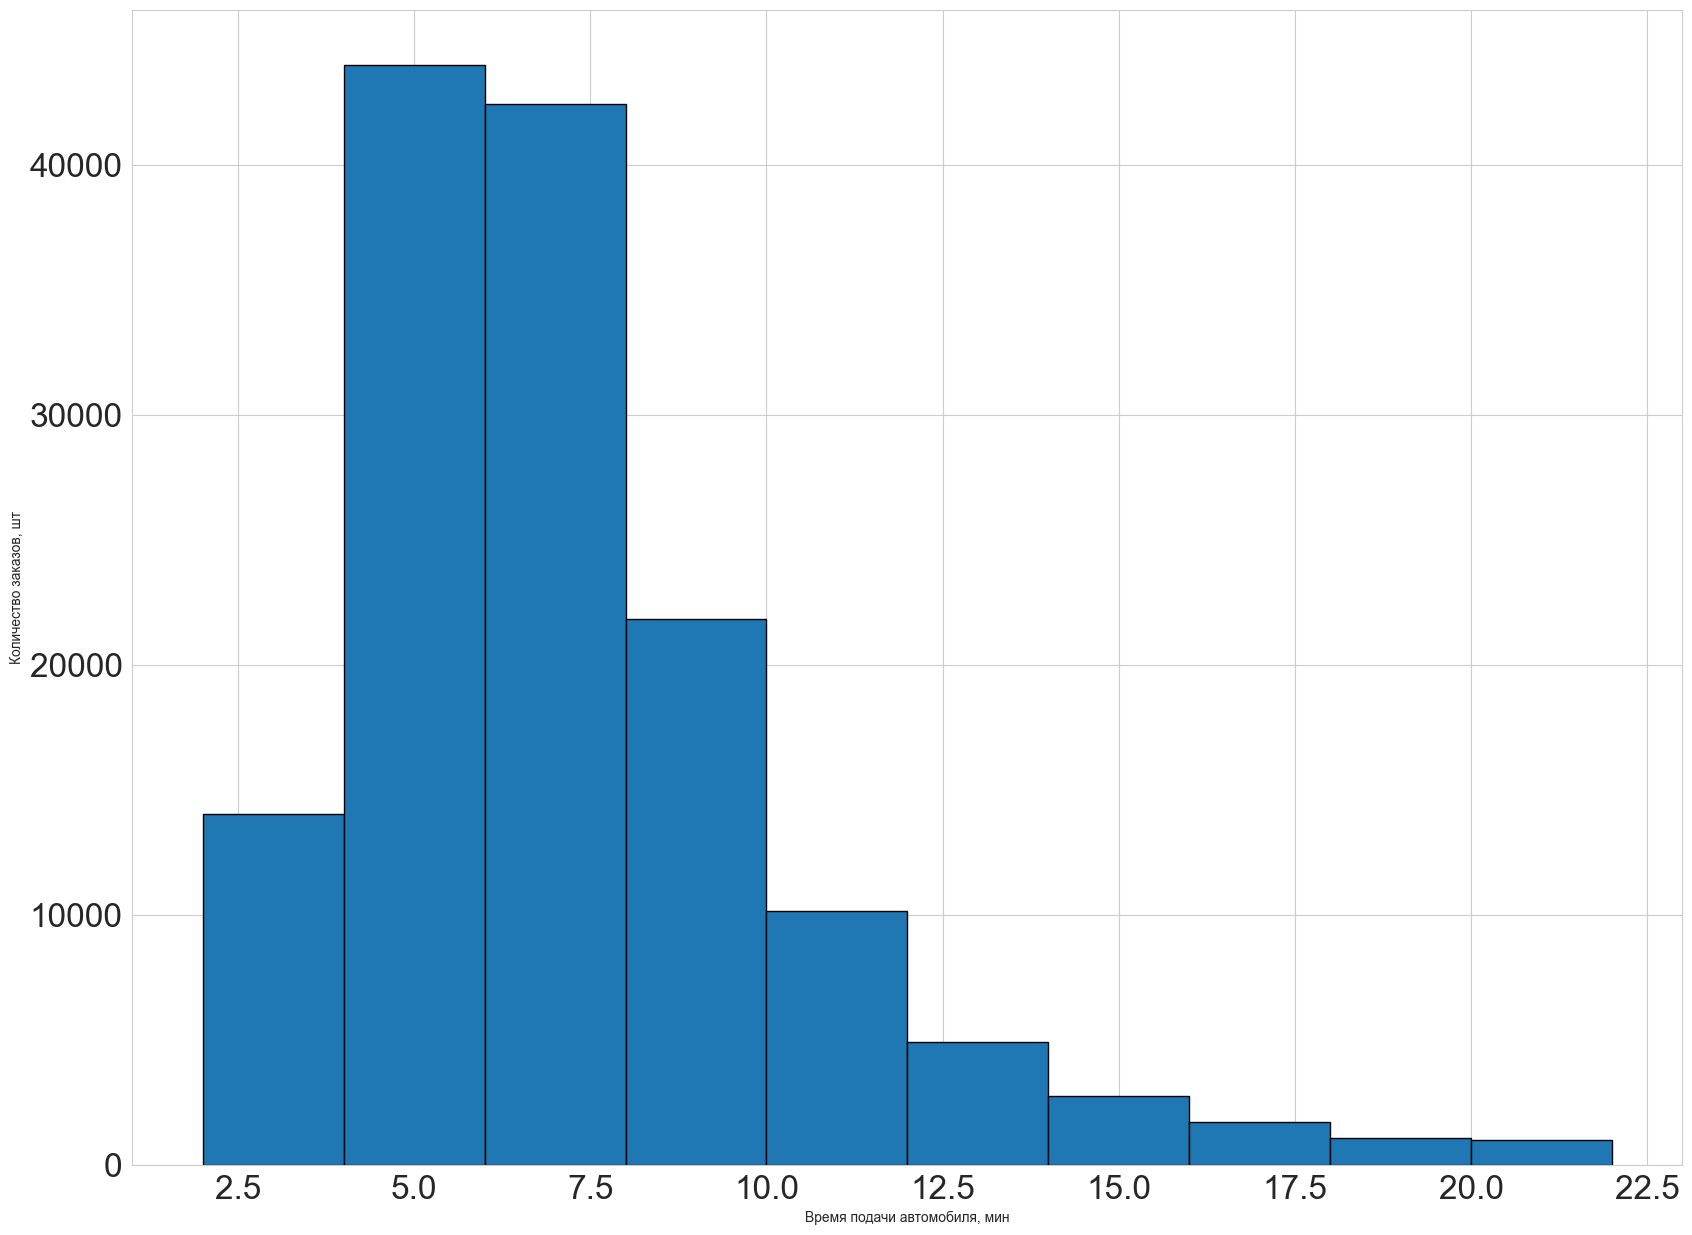

In [34]:
#выведем график с распределением времени подачи
dataset['Расчетное время подачи'].plot(kind='hist', edgecolor='black',xlabel="Время подачи автомобиля, мин", ylabel="Количество заказов, шт", fontsize = 24, figsize = (20, 15))

In [35]:
#покажем корреляцию признаков с целевой переменной
dataset[['Расчетное время подачи', 'Нагрузка на район', 'Количество водителей в радиусе 500м', 'Количество водителей в радиусе 1000м','Количество водителей в радиусе 2000м', 'Расстояние до первого ближайшего водителя', 'Расстояние до второго ближайшего водителя', 'Расстояние до третьего ближайшего водителя' , 'Вероятность отказа от заказа водителя в радиусе 500м', 'Вероятность отказа от заказа водителя в радиусе 1000м', 'Вероятность отказа от заказа водителя в радиусе 2000м', 'Вероятность отказа от заказа первого ближайшего водителя', 'Вероятность отказа от заказа второго ближайшего водителя', 'Вероятность отказа от заказа третьего ближайшего водителя', 'Количество заказов вокруг']].corr()['Расчетное время подачи'][:].sort_values(ascending=False)

Расчетное время подачи                                       1.000000
Расстояние до второго ближайшего водителя                    0.198166
Расстояние до третьего ближайшего водителя                   0.196529
Расстояние до первого ближайшего водителя                    0.188707
Вероятность отказа от заказа водителя в радиусе 500м         0.115974
Вероятность отказа от заказа водителя в радиусе 1000м        0.073019
Вероятность отказа от заказа водителя в радиусе 2000м        0.029513
Вероятность отказа от заказа первого ближайшего водителя     0.025727
Вероятность отказа от заказа второго ближайшего водителя     0.008987
Вероятность отказа от заказа третьего ближайшего водителя    0.002066
Нагрузка на район                                           -0.019168
Количество заказов вокруг                                   -0.035927
Количество водителей в радиусе 2000м                        -0.041325
Количество водителей в радиусе 1000м                        -0.068280
Количество водителей

In [36]:
#создаем функцию, которая будет показывать результаты обучения
def show_learning_results(y_test, y_pred):
    #округляем полученный результат, так как необходимо целое число минут
    y_pred = y_pred.round()
    
    #вычисляем разницу между действительными и предсказанными значениями
    delta_y = y_test - y_pred
    
    #строим график, показывающий отклонения в прогнозах
    delta_y.plot(kind='hist', edgecolor='black', xlabel="Разница между истинным и прогнозируемым значением", ylabel="Количество заказов", figsize = (20, 15), fontsize = 24)

    #выводим значение коэффициента детерминации 
    print(r2_score(y_test, y_pred))
    
    #выводим значение метрики качества
    print('Корень из средней квадратичной ошибки = ',root_mean_squared_error(y_test, y_pred))

    #строим график с точками координаты которых истинное и предсказанное значение
    fig, ax = plt.subplots()  
    ax.scatter(y_test, y_pred) 
    delta_y = delta_y.abs()
    
    #получаем количество прогнозов
    count_delta = len(delta_y)
    
    #фильтруем прогнозы по разнице с истинным значением
    delta_y_less_1m = delta_y[delta_y <= 1]
    delta_y_less_2m = delta_y[delta_y <= 2]
    delta_y_less_3m = delta_y[delta_y <= 3]
    delta_y_less_4m = delta_y[delta_y <= 4]
    delta_y_more_5m = delta_y[delta_y >= 5]

    #выводим результаты какой процент заказов имеет определенное отклонение
    print(len(delta_y_less_1m) / count_delta * 100,'%', '- разница меньше минуты')
    print(len(delta_y_less_2m) / count_delta * 100,'%', '- разница меньше двух минут')
    print(len(delta_y_less_3m) / count_delta * 100,'%', '- разница меньше трех минут')
    print(len(delta_y_less_4m) / count_delta * 100,'%', '- разница меньше четырех минут')
    print(len(delta_y_more_5m) / count_delta * 100,'%', '- разница больше пяти минут')

In [37]:
#создаем функцию, которая будет показывать важность признаков для модели
def show_feature_importance(feature_importance, count):
    
    #создаем отдельный датафрейм для визуализации
    final_df = pd.DataFrame({"Признак" : pd.DataFrame(X).columns, "Важность" : feature_importance})
    final_df.set_index('Важность')
    
    #сортируем признаки по возрастанию для лучшей визуализации
    final_df = final_df.sort_values('Важность')
    
    #выводим на график
    final_df.tail(count).plot.barh(x="Признак", color = 'teal', figsize = (25, 20), xlabel = 'Важность, %', ylabel = 'Признак', fontsize = 30)

In [38]:
#задаем seed для воспроизведения результата
Seed = 2024

In [39]:
#выделяем целевую переменную из датасета
y = dataset['Расчетное время подачи']

#выделяем признаки из датасета
X = dataset.drop(['Расчетное время подачи', 'DeltaTime', 'Date', 'OrderId', 'ArrivalDriverDate', 'OrderCreationDate', 'SetDriverDate'], axis=1)

#формируем тренировочный и тестовый наборы
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=Seed)

In [40]:
#задаем значения для гиперпараметров, которые будут перебираться случайным поиском 
param_grid_randomized_search = {
    'iterations': np.arange(600, 3000, 200),
    'learning_rate': np.arange(0.01, 0.2, 0.02),
    'depth': np.arange(2, 12, 2)
}

#выделяем категориальные признаки для CatBoost
cat_features = [3, 7]

#создаем модель CatBoost
model = CatBoostRegressor(verbose=False, cat_features=cat_features, loss_function='RMSE')

#создаем экземпляр случайного поиска для нахождения лучших гиперпараметров 
random_search = RandomizedSearchCV(model, param_grid_randomized_search, cv=5, n_jobs= 5, random_state=Seed, scoring='neg_root_mean_squared_error', n_iter=40)

#запускаем процесс обучения и подбора гиперпараметров
random_search.fit(x_train, y_train)

In [41]:
#выводим лучшие результаты
print(random_search.best_params_)
print(random_search.best_score_)

{'learning_rate': 0.03, 'iterations': 1200, 'depth': 6}
-2.9381406623057122


In [42]:
#выводим результаты полученные в ходе работы алгоритма случайного поиска
rs_df = pd.DataFrame(random_search.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'split3_test_score',
            'split4_test_score',
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_learning_rate,param_iterations,param_depth,mean_test_score,rank_test_score
0,0.03,1200,6,-2.938141,1
1,0.03,2600,6,-2.938410,2
2,0.05,600,6,-2.940036,3
3,0.13,1200,4,-2.940542,4
4,0.07,2400,2,-2.941698,5
5,0.03,1200,4,-2.941728,6
6,0.17,1200,2,-2.942052,7
7,0.11,1600,2,-2.942157,8
8,0.13,1200,2,-2.942339,9
9,0.17,2000,2,-2.942795,10


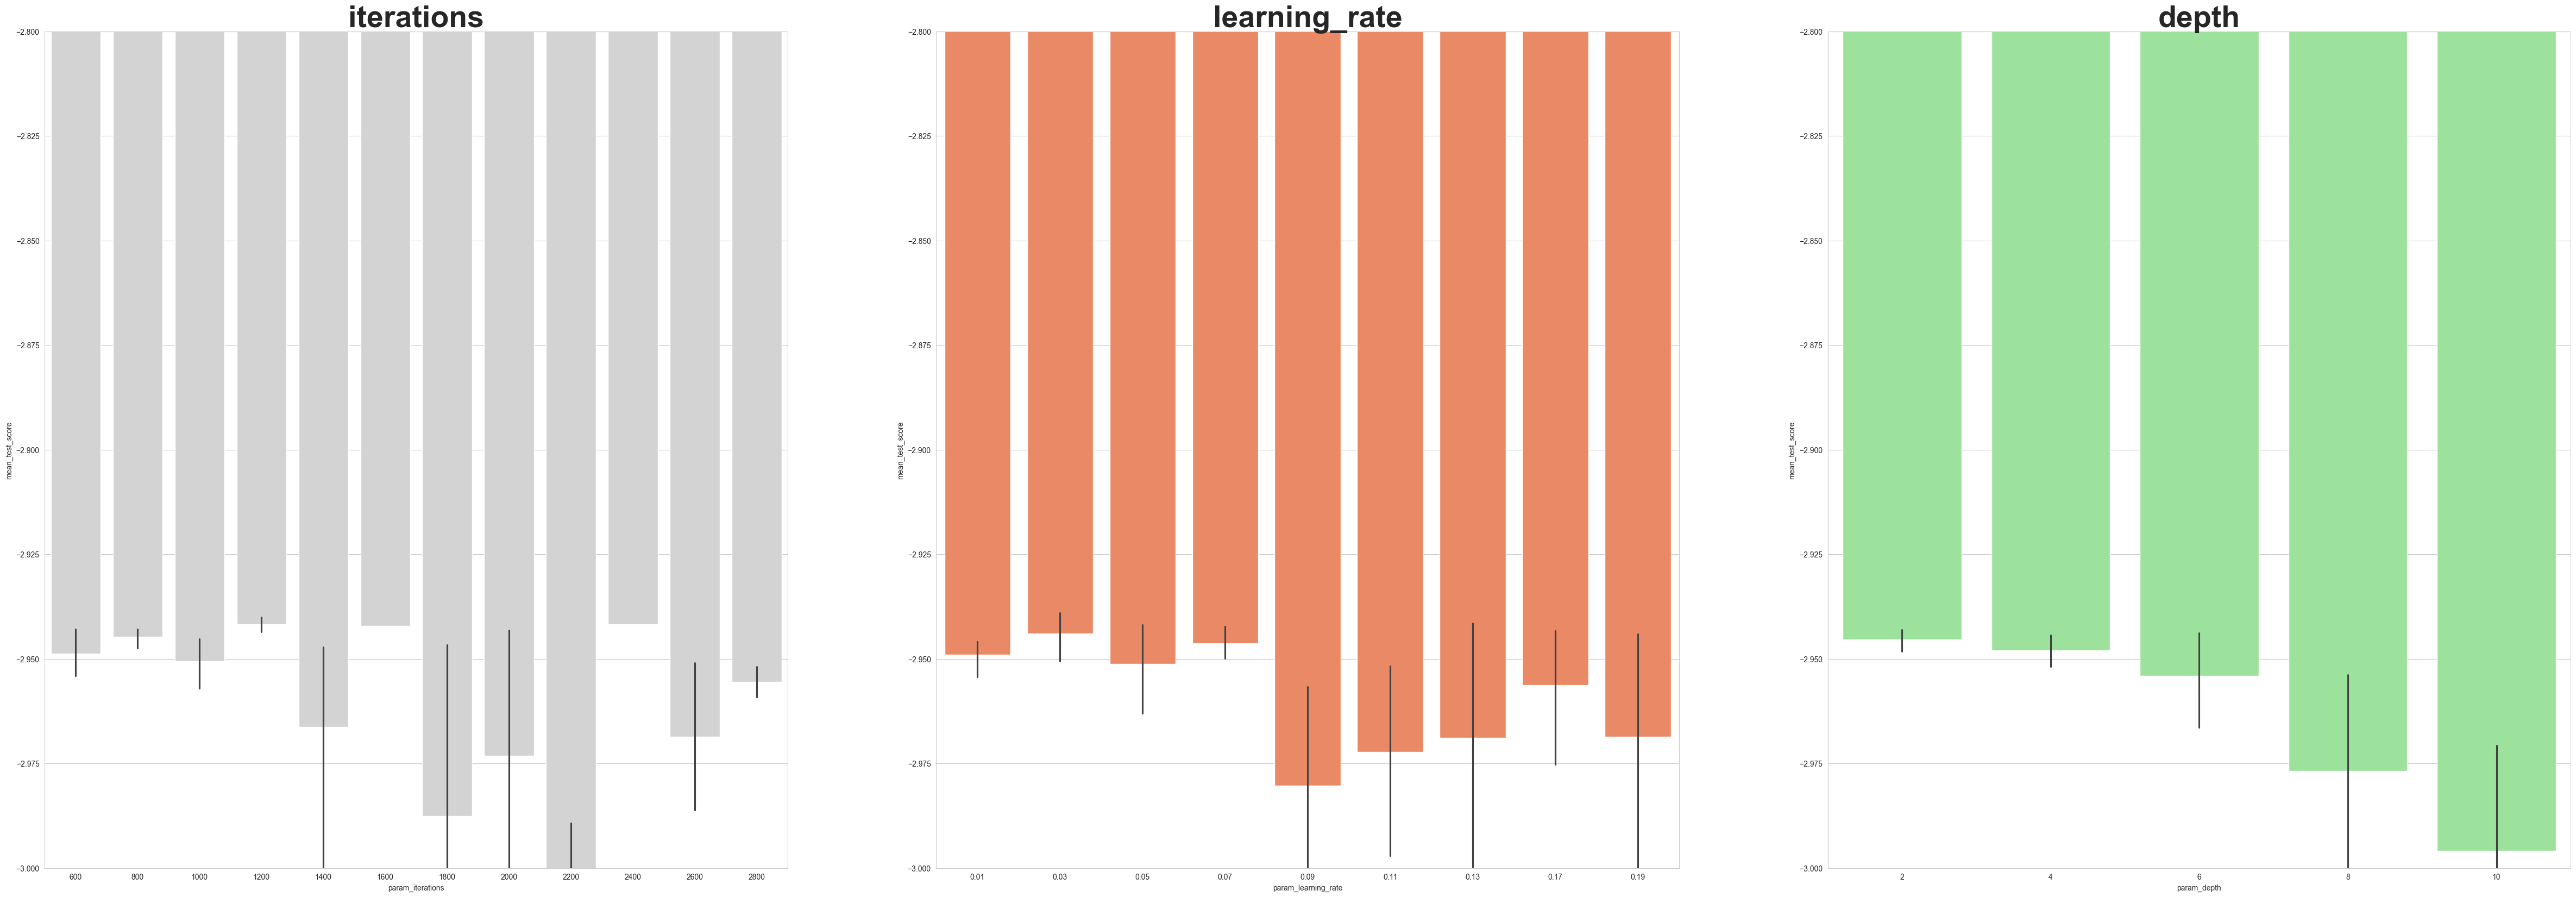

In [43]:
#построим графики с полученной метрикой качества по гиперпараметрам
fig, axs = plt.subplots(ncols=3)
sns.set(style="whitegrid", color_codes=True, font_scale=2.9)
fig.set_size_inches(60, 20)
sns.barplot(x='param_iterations', y='mean_test_score', data=rs_df, ax=axs[0], color='lightgrey')
axs[0].set_ylim([-3, -2.8])
axs[0].set_title(label='iterations', size=40, weight='bold')
sns.barplot(x=rs_df['param_learning_rate'].astype(np.float32), y=rs_df['mean_test_score'], ax=axs[1], color='coral')
axs[1].set_ylim([-3, -2.8])
axs[1].set_title(label='learning_rate', size=40, weight='bold')
sns.barplot(x='param_depth', y='mean_test_score', data=rs_df, ax=axs[2], color='lightgreen')
axs[2].set_ylim([-3, -2.8])
axs[2].set_title(label='depth', size=40, weight='bold')
plt.show()

In [44]:
#задаем значения для гиперпараметров, которые будут перебираться алгоритмом поиска по сетке
param_grid = {
    'iterations': [600,800,1000,1200,1600,2400,2800],
    'learning_rate': [0.01,0.03,0.05,0.7,0.17],
    'depth': [2,4,6]
}

#выделяем категориальные признаки для CatBoost
cat_features = [3, 7]

#создаем модель CatBoost
model = CatBoostRegressor(verbose=False, cat_features=cat_features, loss_function='RMSE')

#создаем экземпляр поиска по сетке для нахождения лучших гиперпараметров 
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs= 5, scoring='neg_root_mean_squared_error')

#запускаем процесс обучения и подбора гиперпараметров
grid_search.fit(x_train, y_train)

#получаем предсказания на тестовых данных
y_pred = grid_search.predict(x_test)

In [45]:
#выводим лучшие результаты
print(grid_search.best_params_)
print(grid_search.best_score_)

{'depth': 6, 'iterations': 1600, 'learning_rate': 0.03}
-2.9374467473964563


0.15305000817282088
Корень из средней квадратичной ошибки =  2.9256962215355653
44.90583084300507 % - разница меньше минуты
68.56626589756064 % - разница меньше двух минут
84.43255264438112 % - разница меньше трех минут
91.0904162902217 % - разница меньше четырех минут
8.909583709778303 % - разница больше пяти минут


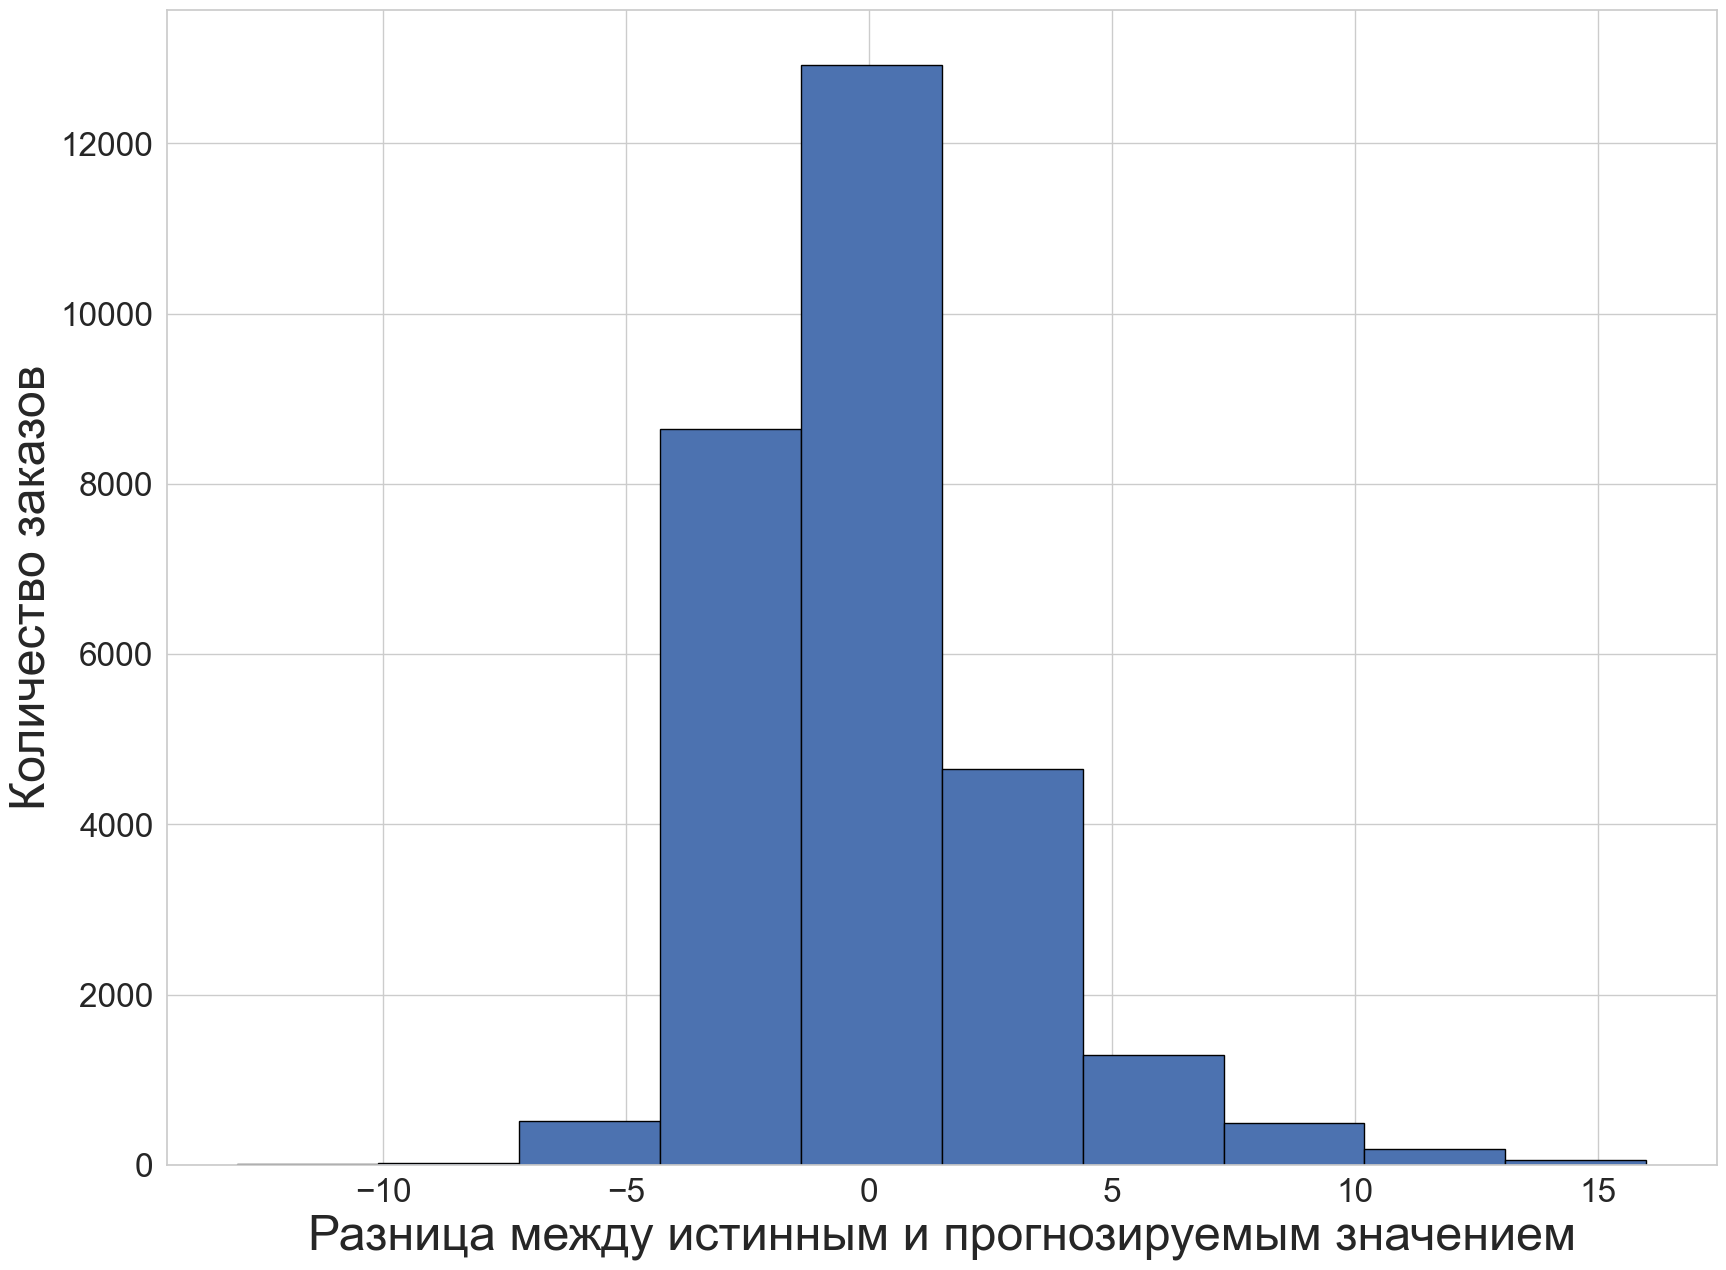

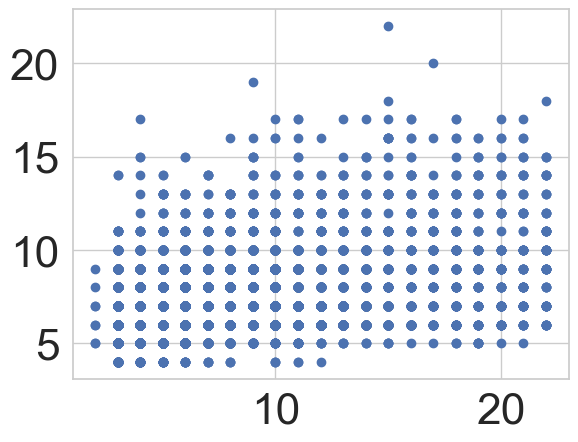

In [46]:
#выводим результаты обучения лучшей модели
show_learning_results(y_test, y_pred)

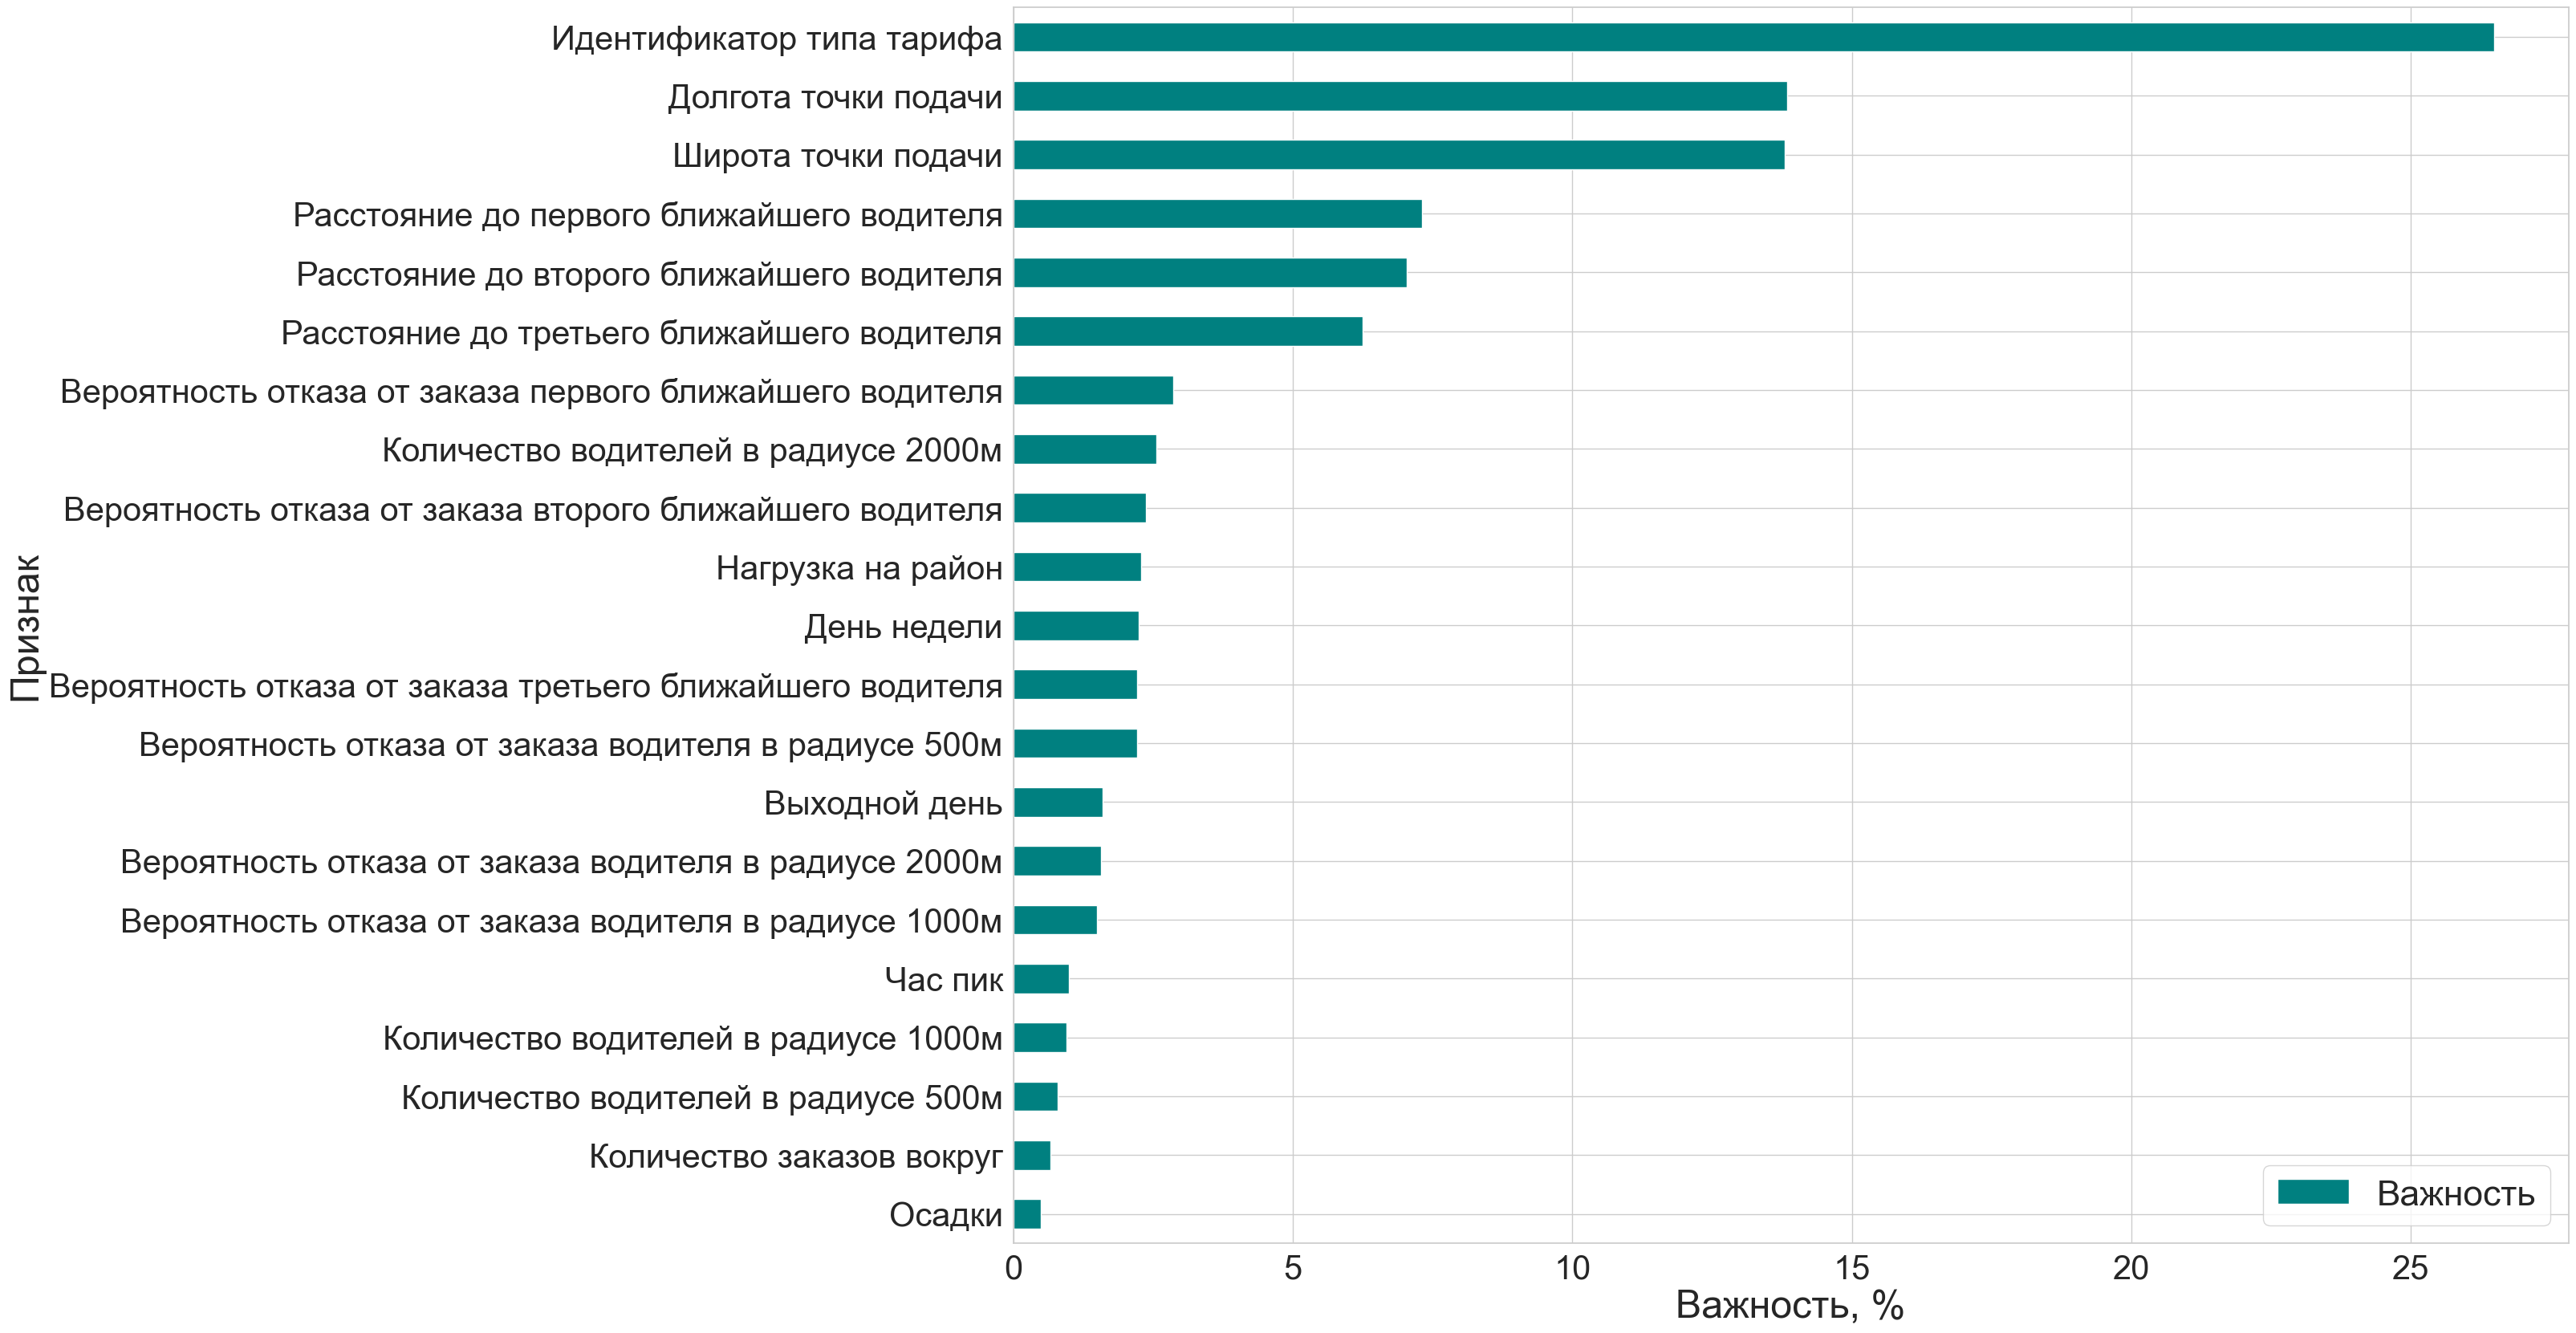

In [48]:
#выводим важность признаков для лучшей модели
show_feature_importance(grid_search.best_estimator_.feature_importances_, 21)

In [49]:
#преобразуем категориальные признаки, использую подход one hot encoded
one_hot_encoded_data = pd.get_dummies(dataset, columns = ['Идентификатор типа тарифа', 'День недели'])
#выводим результаты
print(one_hot_encoded_data)

           OrderId  Расчетное время подачи           SetDriverDate  \
0       3544585460                       5 2024-02-15 00:18:53.997   
1       3544585488                       4 2024-02-15 00:01:58.203   
2       3544585545                       4 2024-02-15 00:10:47.800   
3       3544585571                       3 2024-02-15 00:06:58.673   
4       3544585572                       5 2024-02-15 00:05:40.380   
...            ...                     ...                     ...   
145643  3549499846                      18 2024-03-13 23:46:41.800   
145644  3549499955                      10 2024-03-13 23:51:20.557   
145645  3549499961                       4 2024-03-13 23:58:55.290   
145646  3549500025                       5 2024-03-13 23:56:31.047   
145647  3549500125                      12 2024-03-14 00:01:33.953   

             ArrivalDriverDate       OrderCreationDate  Нагрузка на район  \
0      2024-02-15 00:20:10.647 2024-02-15 05:00:25.540               1.25   
1    

In [50]:
display(one_hot_encoded_data)

#выделяем целевую переменную из датасета
y = one_hot_encoded_data['Расчетное время подачи']

#выделяем признаки из датасета
X = one_hot_encoded_data.drop(['Расчетное время подачи', 'DeltaTime', 'Date', 'OrderId', 'ArrivalDriverDate', 'OrderCreationDate', 'SetDriverDate'], axis=1)

#формируем тренировочный и тестовый наборы
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=Seed)

,OrderId,Расчетное время подачи,SetDriverDate,ArrivalDriverDate,OrderCreationDate,Нагрузка на район,Широта точки подачи,Долгота точки подачи,Выходной день,Час пик,...,Идентификатор типа тарифа_1456,Идентификатор типа тарифа_1457,Идентификатор типа тарифа_1475,День недели_Воскресенье,День недели_Вторник,День недели_Понедельник,День недели_Пятница,День недели_Среда,День недели_Суббота,День недели_Четверг
0,3544585460,5,2024-02-15 00:18:53.997,2024-02-15 00:20:10.647,2024-02-15 05:00:25.540,1.25,57.181877,65.656975,0,0,...,False,False,False,False,False,False,False,False,False,True
1,3544585488,4,2024-02-15 00:01:58.203,2024-02-15 00:03:33.630,2024-02-15 05:00:58.053,1.35,57.127262,65.581718,0,0,...,False,False,False,False,False,False,False,False,False,True
2,3544585545,4,2024-02-15 00:10:47.800,2024-02-15 00:13:19.677,2024-02-15 05:02:45.250,1.20,57.146118,65.522736,0,0,...,False,False,False,False,False,False,False,False,False,True
3,3544585571,3,2024-02-15 00:06:58.673,2024-02-15 00:07:50.340,2024-02-15 05:03:29.623,1.25,57.146656,65.521637,0,0,...,False,False,False,False,False,False,False,False,False,True
4,3544585572,5,2024-02-15 00:05:40.380,2024-02-15 00:10:34.873,2024-02-15 05:03:29.733,1.35,57.145397,65.585876,0,0,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145643,3549499846,18,2024-03-13 23:46:41.800,2024-03-14 00:05:44.097,2024-03-14 04:44:52.303,1.00,57.115326,65.560928,0,0,...,False,False,False,False,False,False,False,False,False,True
145644,3549499955,10,2024-03-13 23:51:20.557,2024-03-14 00:02:07.323,2024-03-14 04:49:52.080,1.00,57.146118,65.522736,0,0,...,False,False,False,False,False,False,False,False,False,True
145645,3549499961,4,2024-03-13 23:58:55.290,2024-03-13 23:59:51.967,2024-03-14 04:50:22.870,1.25,57.147602,65.642136,0,0,...,False,False,False,False,False,False,False,False,False,True
145646,3549500025,5,2024-03-13 23:56:31.047,2024-03-14 00:00:43.637,2024-03-14 04:53:47.267,1.25,57.095970,65.566177,0,0,...,False,False,False,False,False,False,False,False,False,True


In [51]:
#задаем значения для гиперпараметров, которые будут перебираться случайным поиском 
param_grid_randomized_search = {
    'n_estimators': np.arange(200, 800, 50),
    'max_depth': np.arange(10, 120, 10),
    'max_features': ['log2', 'sqrt'],
    'min_samples_split': np.arange(2, 103, 10),
    'min_samples_leaf': np.arange(1, 11, 1),
    'bootstrap': [True, False]
}

#создаем модель RandomForest
model = RandomForestRegressor(random_state=Seed)

#создаем экземпляр случайного поиска для нахождения лучших гиперпараметров 
random_search = RandomizedSearchCV(model, param_grid_randomized_search, cv=5, n_jobs=5, random_state=Seed,
                                   scoring='neg_root_mean_squared_error', n_iter=40)

#запускаем процесс обучения и подбора гиперпараметров
random_search.fit(x_train, y_train)

#выводим лучшие результаты
print(random_search.best_params_)
print(random_search.best_score_)

{'n_estimators': 350, 'min_samples_split': 72, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': False}
-2.9592267574031643


In [52]:
#выводим результаты полученные в ходе работы алгоритма случайного поиска
rs_df = pd.DataFrame(random_search.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,split3_test_score,split4_test_score,mean_test_score,rank_test_score
0,350,72,1,sqrt,90,False,-2.967494,-2.975071,-2.959227,1
1,350,82,4,sqrt,80,False,-2.968934,-2.975176,-2.960050,2
2,400,52,3,sqrt,90,False,-2.969201,-2.976478,-2.960055,3
3,500,42,4,sqrt,90,False,-2.970141,-2.976214,-2.960351,4
4,550,32,2,sqrt,20,True,-2.969468,-2.975702,-2.960359,5
5,550,62,7,sqrt,90,False,-2.970171,-2.976603,-2.961339,6
6,750,72,2,sqrt,20,True,-2.969302,-2.976233,-2.961375,7
7,650,92,6,sqrt,20,False,-2.969849,-2.976795,-2.961670,8
8,300,62,2,log2,80,False,-2.971617,-2.976138,-2.961849,9
9,650,42,1,log2,40,True,-2.972535,-2.975546,-2.962144,10


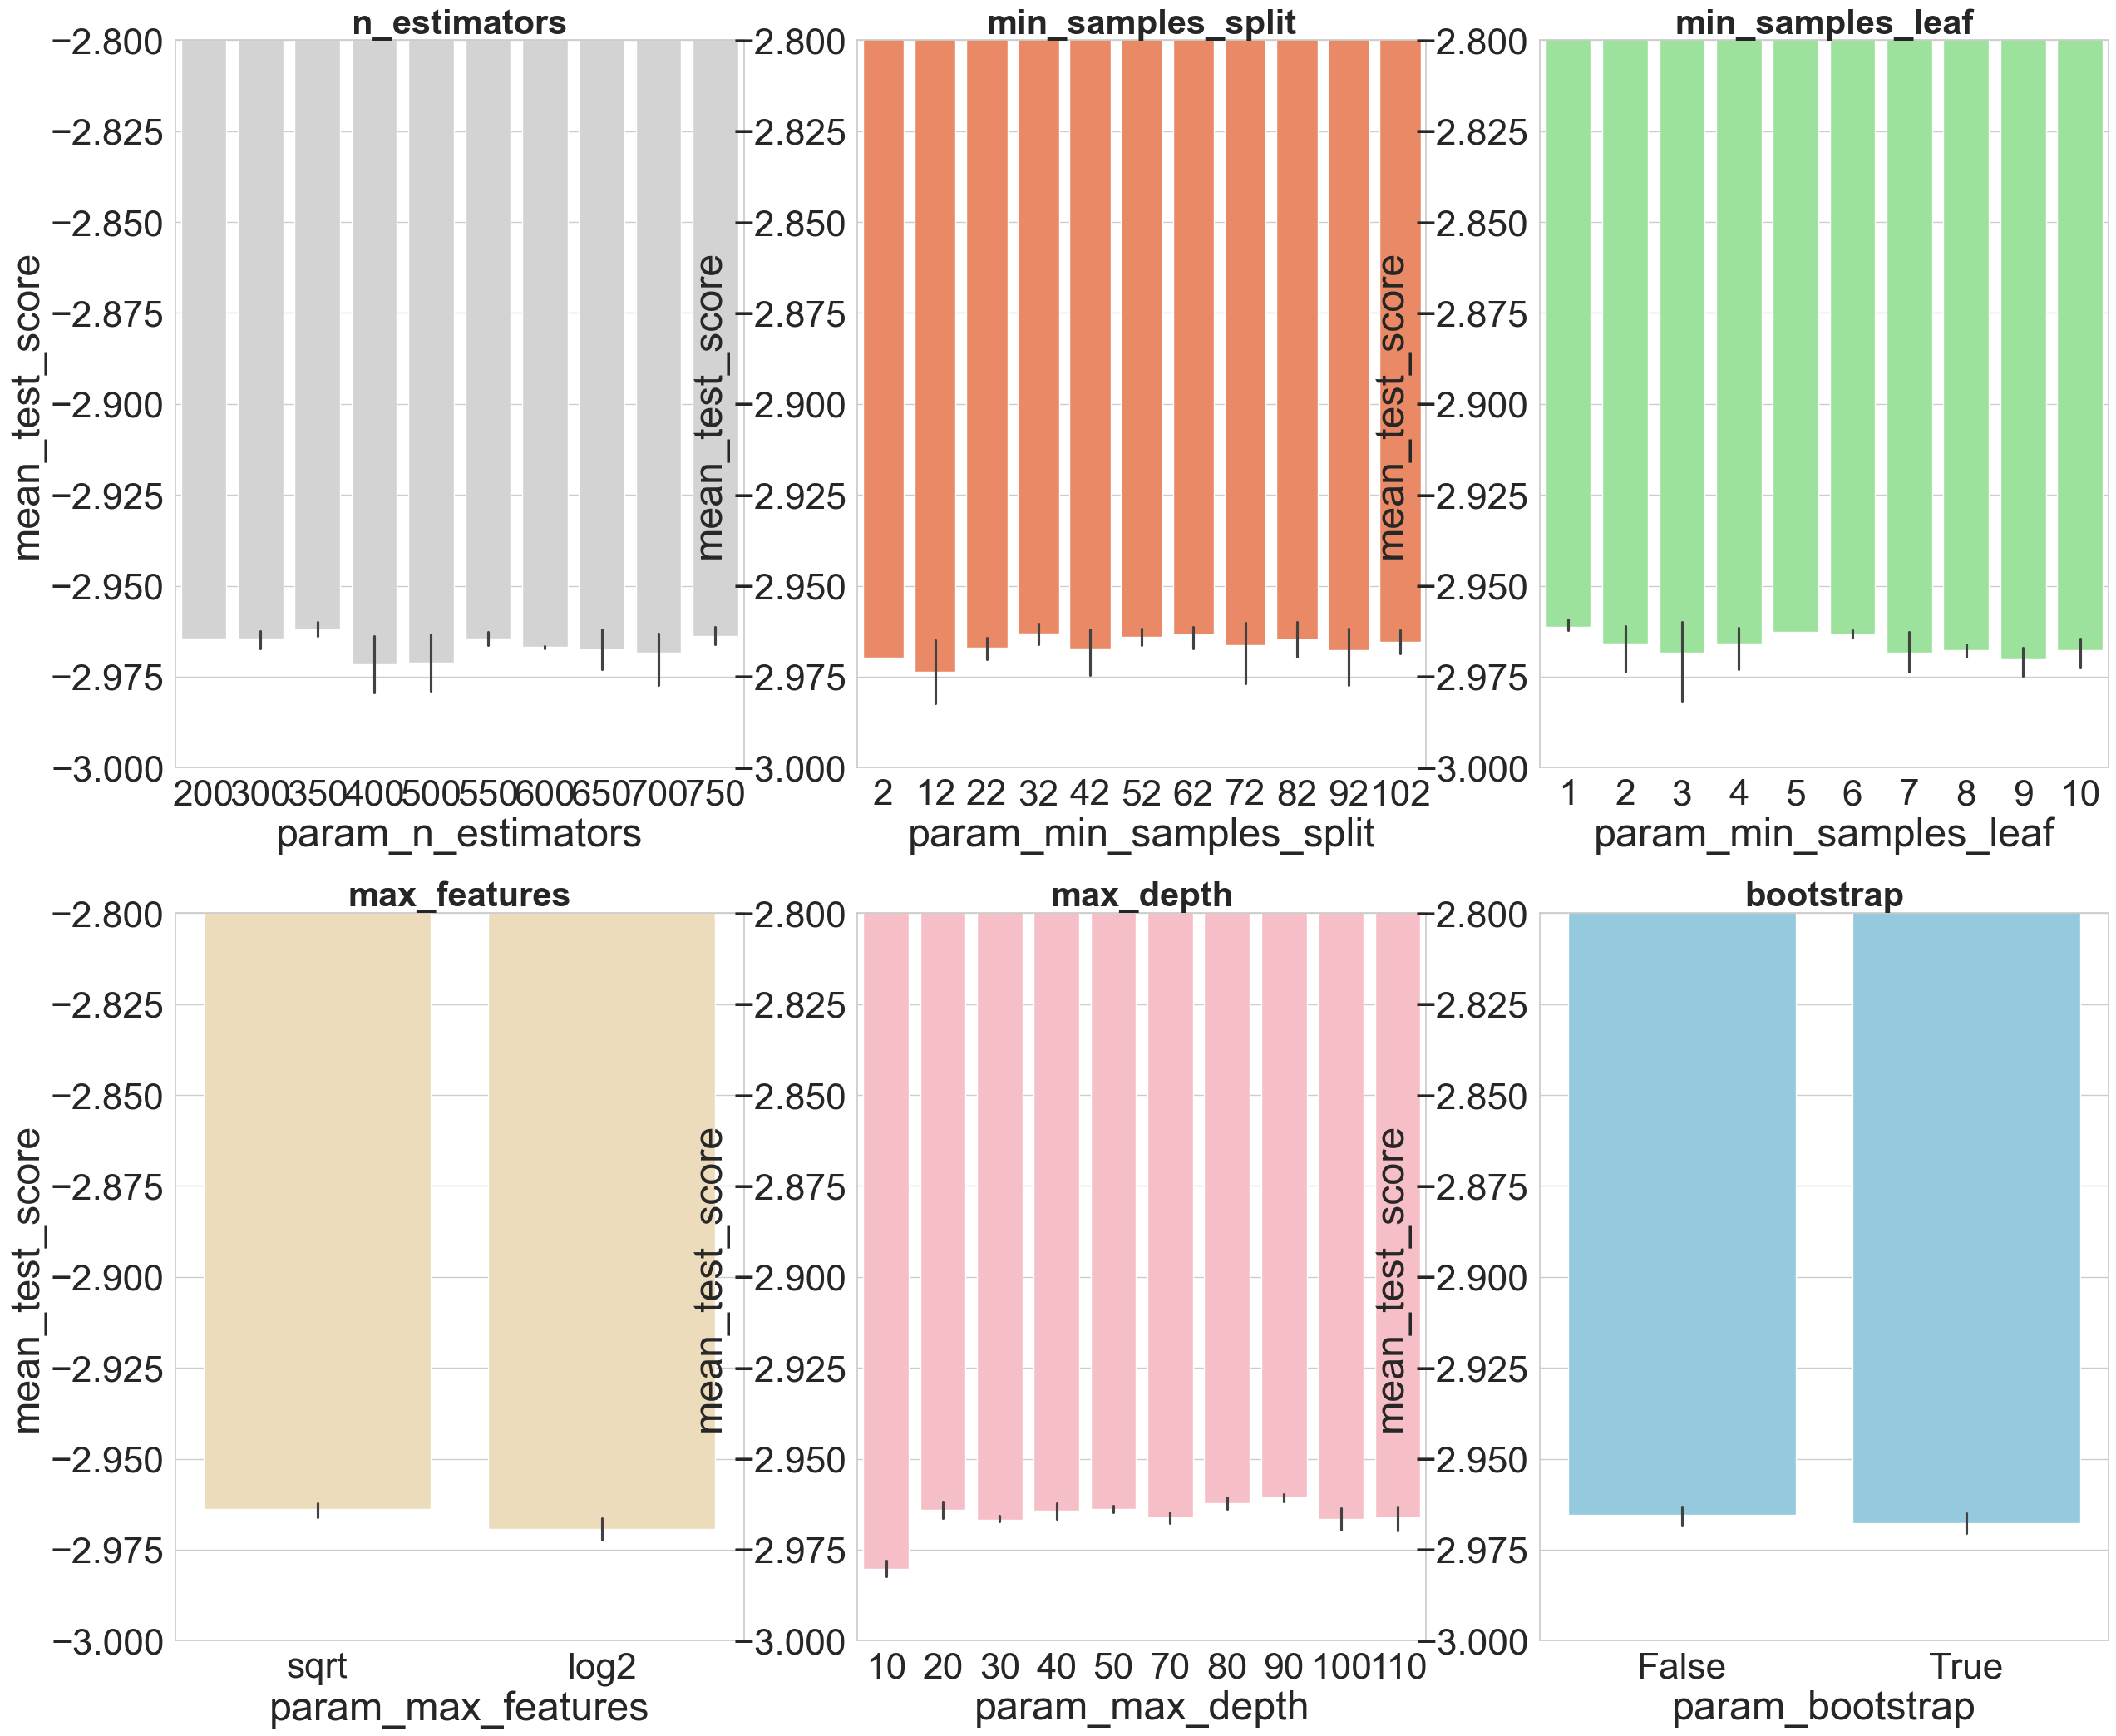

In [53]:
#построим графики с полученной метрикой качества по гиперпараметрам
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([-3, -2.8])
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([-3, -2.8])
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([-3, -2.8])
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([-3, -2.8])
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([-3, -2.8])
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([-3, -2.8])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()

In [54]:
#задаем значения для гиперпараметров, которые будут перебираться алгоритмом поиска по сетке
param_grid = {
    'n_estimators': [350, 550, 650, 700, 750],
    'max_depth': [20, 40, 50, 80, 90],
    'min_samples_split': [32, 52, 62, 72, 82, 102],
    'min_samples_leaf': [1, 3, 4, 5, 6, 7],
}

#создаем модель RandomForest
model = RandomForestRegressor(random_state=Seed, bootstrap=False, max_features='sqrt')

#создаем экземпляр поиска по сетке для нахождения лучших гиперпараметров 
grid_search = GridSearchCV(model, param_grid, cv=3, n_jobs= 5, scoring='neg_root_mean_squared_error')

#запускаем процесс обучения и подбора гиперпараметров
grid_search.fit(x_train, y_train)

#получаем предсказания на тестовых данных
y_pred = grid_search.predict(x_test)

In [55]:
#выводим лучшие результаты
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 62, 'n_estimators': 650}
-2.960864475882856


0.1422882547823865
Корень из средней квадратичной ошибки =  2.9442251985196894
44.11355896865661 % - разница меньше минуты
67.6037250677601 % - разница меньше двух минут
84.14761275974702 % - разница меньше трех минут
90.99311974424909 % - разница меньше четырех минут
9.006880255750922 % - разница больше пяти минут


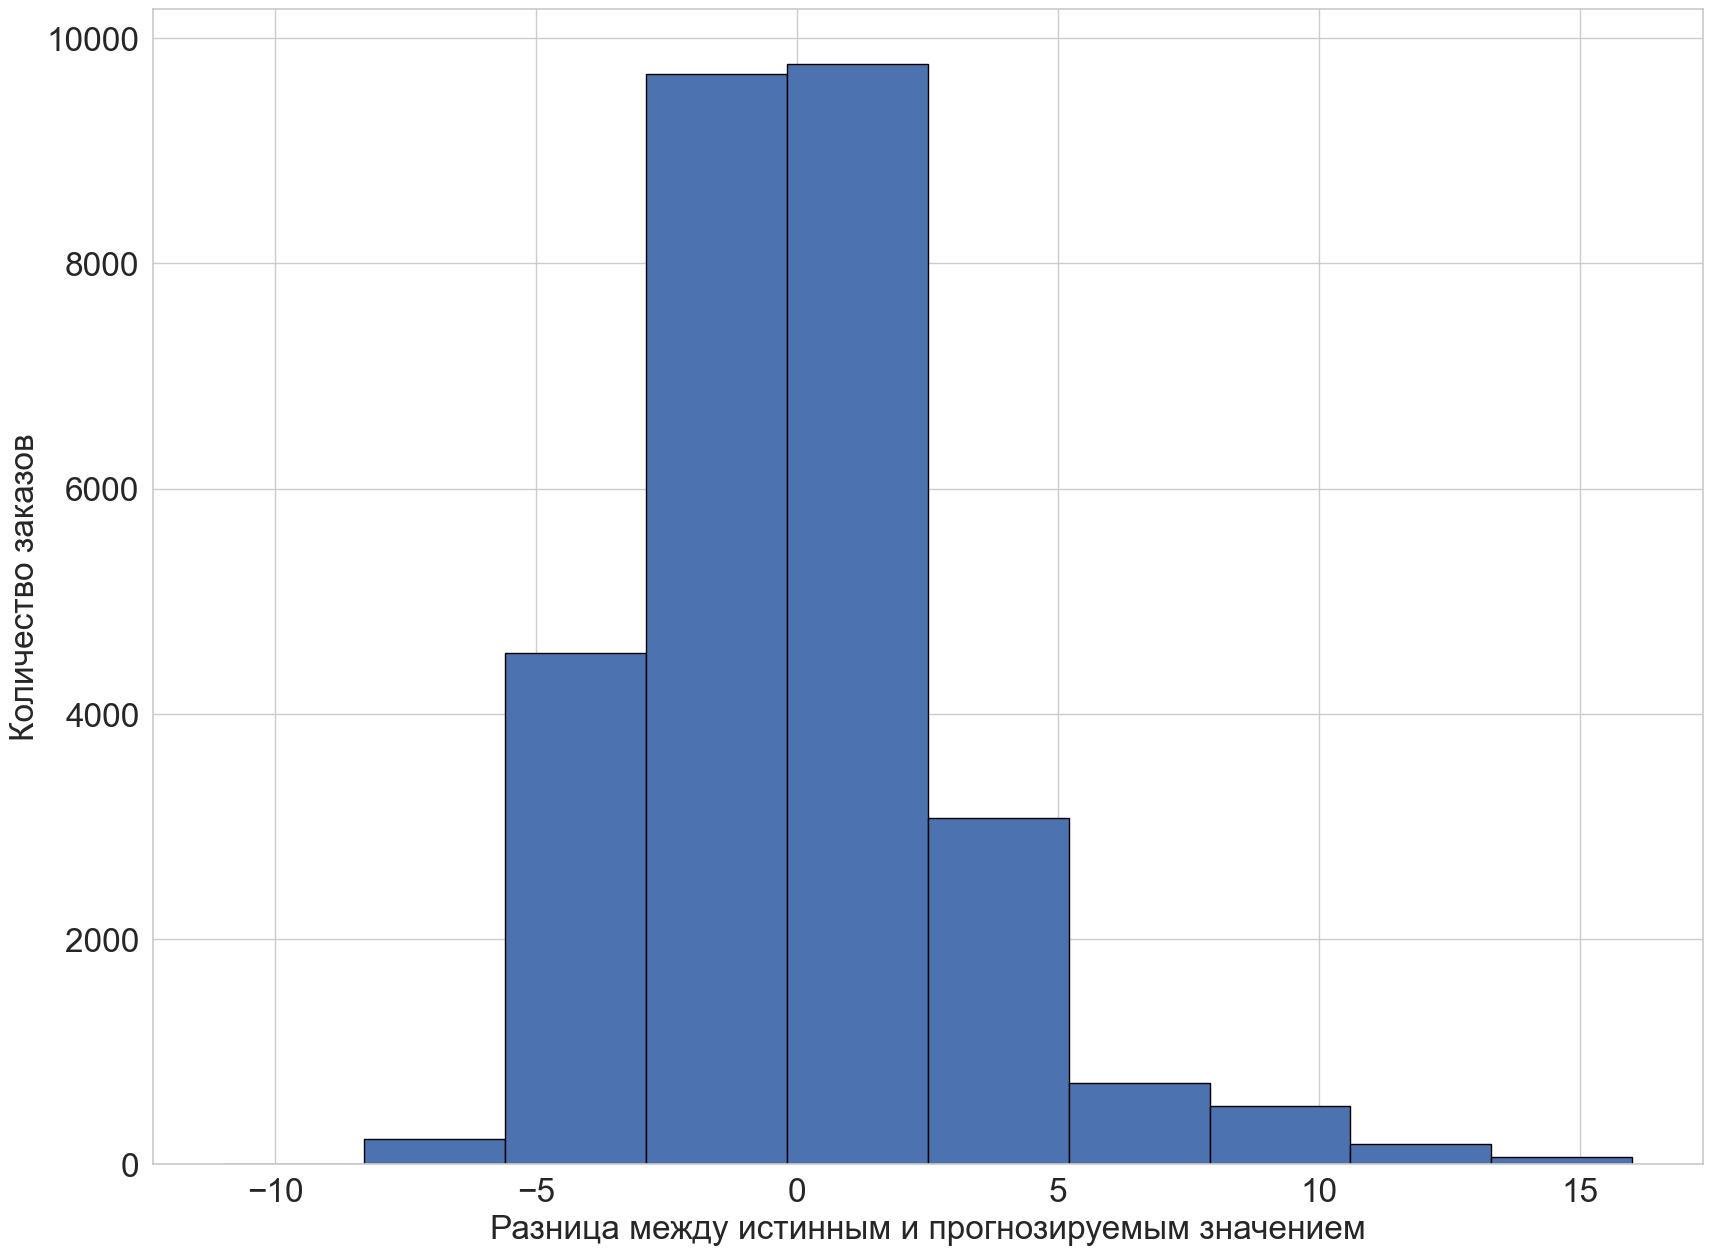

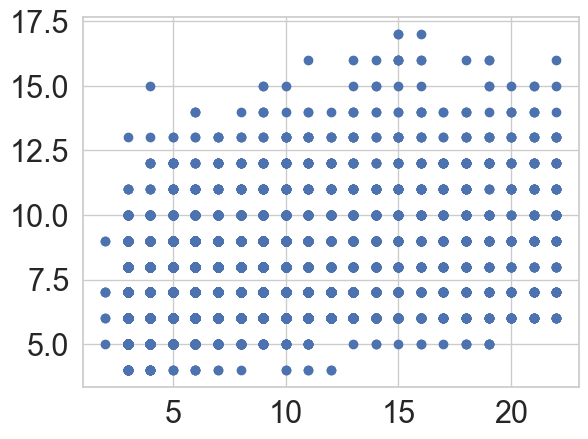

In [56]:
#выводим результаты обучения лучшей модели
show_learning_results(y_test, y_pred)

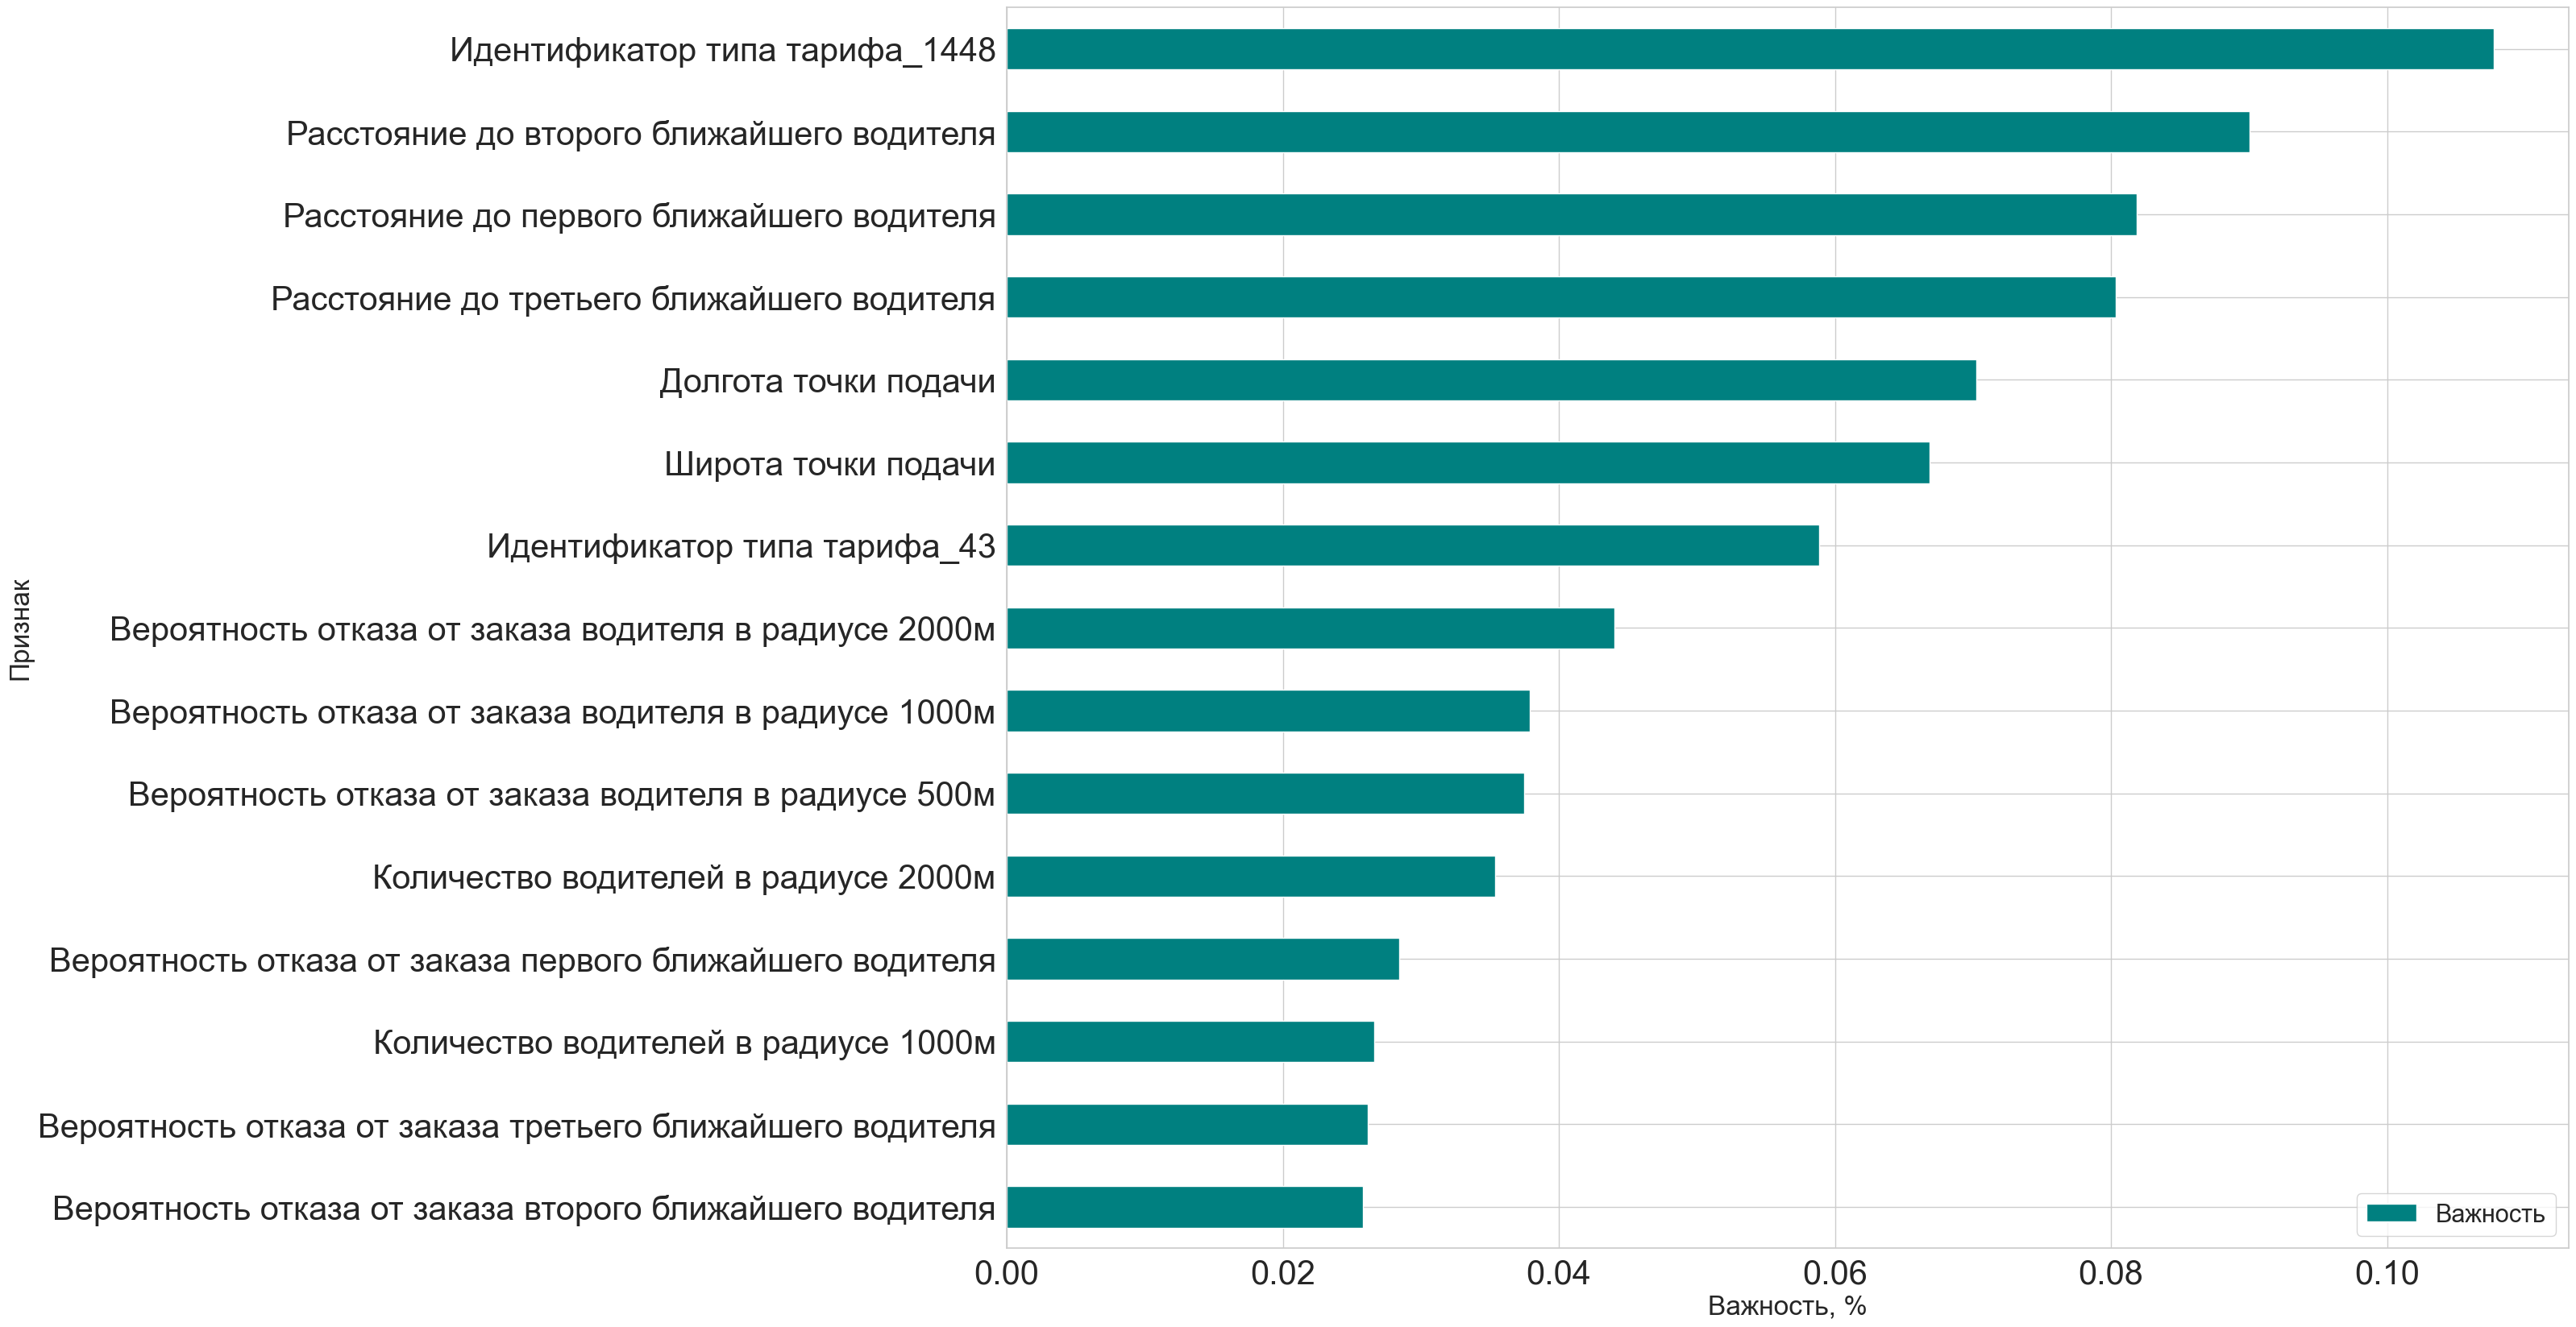

In [57]:
#выводим важность признаков для лучшей модели
show_feature_importance(grid_search.best_estimator_.feature_importances_, 15)

In [65]:
#создаем экземпляр класса MinMaxScaler
minmax = MinMaxScaler(feature_range = (0, 1))

#нормализуем данные
one_hot_encoded_data_scaled = minmax.fit_transform(one_hot_encoded_data)

# преобразуем результаты в датафрейм
one_hot_encoded_data_scaled = pd.DataFrame(one_hot_encoded_data_scaled, columns = one_hot_encoded_data.columns)

#выводим результат
display(one_hot_encoded_data_scaled)

#выделяем признаки из датасета
X = one_hot_encoded_data_scaled

#формируем тренировочный и тестовый наборы
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=Seed)

,Нагрузка на район,Широта точки подачи,Долгота точки подачи,Выходной день,Час пик,Осадки,Количество водителей в радиусе 500м,Количество водителей в радиусе 1000м,Количество водителей в радиусе 2000м,Расстояние до первого ближайшего водителя,...,Идентификатор типа тарифа_1456,Идентификатор типа тарифа_1457,Идентификатор типа тарифа_1475,День недели_Воскресенье,День недели_Вторник,День недели_Понедельник,День недели_Пятница,День недели_Среда,День недели_Суббота,День недели_Четверг
0,0.5,0.599448,0.587795,0.0,0.0,0.0,0.000000,0.00,0.033333,0.039008,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.7,0.491556,0.511799,0.0,0.0,0.0,0.052632,0.20,0.066667,0.012218,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.4,0.528806,0.452237,0.0,0.0,0.0,0.210526,0.08,0.066667,0.003959,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.5,0.529869,0.451128,0.0,0.0,0.0,0.210526,0.08,0.083333,0.001570,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.7,0.527382,0.515998,0.0,0.0,0.0,0.000000,0.04,0.083333,0.032626,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143882,0.0,0.467976,0.490805,0.0,0.0,0.0,0.157895,0.08,0.116667,0.007747,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
143883,0.0,0.528806,0.452237,0.0,0.0,0.0,0.210526,0.12,0.133333,0.002287,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
143884,0.5,0.531738,0.572810,0.0,0.0,0.0,0.000000,0.04,0.033333,0.026585,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
143885,0.5,0.429738,0.496105,0.0,0.0,0.0,0.052632,0.00,0.033333,0.011433,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [67]:
#задаем значения для гиперпараметров, которые будут перебираться случайным поиском
param_grid_randomized_search = {
    'kernel': ['rbf', 'poly', 'linear'],
    'C': np.arange(1.4, 4.1, 0.2), 
    'epsilon': np.arange(1.4, 4.1, 0.2), 
}

#создаем модель SVR
svr = SVR()

#создаем экземпляр случайного поиска для нахождения лучших гиперпараметров 
random_search = RandomizedSearchCV(svr, param_grid_randomized_search, cv=3, n_jobs= 5, random_state=Seed, scoring='neg_root_mean_squared_error', n_iter=15)

#запускаем процесс обучения и подбора гиперпараметров
random_search.fit(x_train, y_train)

#выводим лучшие результаты
print(random_search.best_params_)
print(random_search.best_score_)

{'kernel': 'rbf', 'epsilon': 2.5999999999999996, 'C': 2.9999999999999996}
-2.983573550431668


In [68]:
#выводим результаты полученные в ходе работы алгоритма случайного поиска
rs_df = pd.DataFrame(random_search.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_kernel,param_epsilon,param_C,mean_test_score,rank_test_score
0,rbf,2.6,3.0,-2.983574,1
1,rbf,2.2,3.8,-2.987867,2
2,linear,2.6,3.2,-2.988885,3
3,linear,2.6,3.6,-2.988919,4
4,rbf,3.0,1.8,-2.989462,5
5,linear,3.0,2.4,-2.989572,6
6,poly,2.2,2.6,-2.992248,7
7,rbf,3.2,1.6,-2.996466,8
8,linear,3.2,3.8,-2.996757,9
9,rbf,3.4,2.6,-3.004008,10


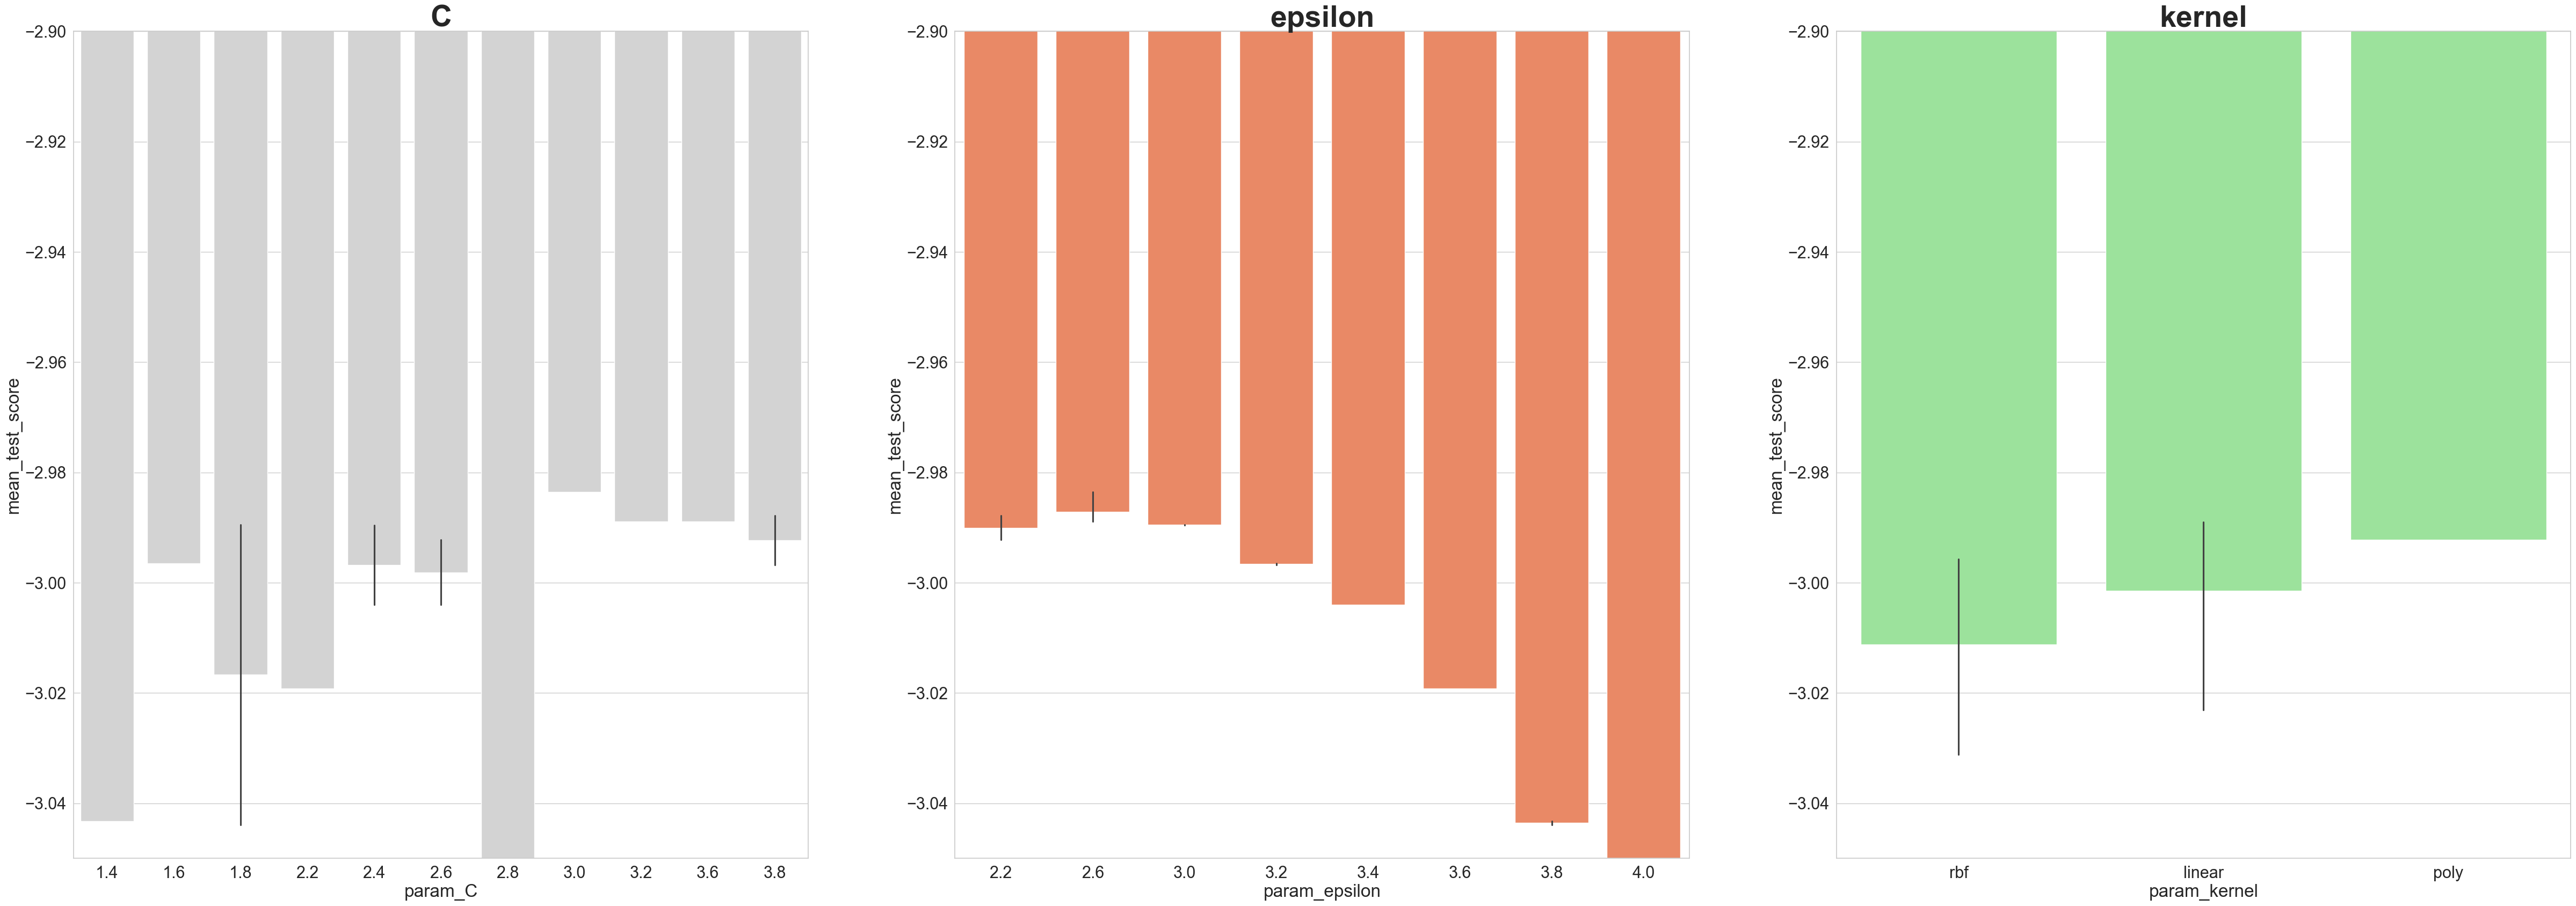

In [69]:
#построим графики с полученной метрикой качества по гиперпараметрам
fig, axs = plt.subplots(ncols=3)
sns.set(style="whitegrid", color_codes=True, font_scale=2.9)
fig.set_size_inches(60, 20)
sns.barplot(x=rs_df['param_C'].astype(np.float32), y=rs_df['mean_test_score'], ax=axs[0], color='lightgrey')
axs[0].set_ylim([-3.05, -2.9])
axs[0].set_title(label='C', size=40, weight='bold')
sns.barplot(x=rs_df['param_epsilon'].astype(np.float32), y=rs_df['mean_test_score'], ax=axs[1], color='coral')
axs[1].set_ylim([-3.05, -2.9])
axs[1].set_title(label='epsilon', size=40, weight='bold')
sns.barplot(x='param_kernel', y='mean_test_score', data=rs_df, ax=axs[2], color='lightgreen')
axs[2].set_ylim([-3.05, -2.9])
axs[2].set_title(label = 'kernel', size=40, weight='bold')
plt.show()

In [70]:
#задаем значения для гиперпараметров, которые будут перебираться алгоритмом поиска по сетке
param_grid = {
    'kernel': ['rbf', 'poly'],
    'C': [3, 3.2, 3.4, 3.6], 
    'epsilon': [2.2, 2.6, 3], 
}

#создаем модель SVR
model = SVR()

#создаем экземпляр поиска по сетке для нахождения лучших гиперпараметров 
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs= 5, scoring='neg_root_mean_squared_error')

#запускаем процесс обучения и подбора гиперпараметров
grid_search.fit(x_train, y_train)

#получаем предсказания на тестовых данных
y_pred = grid_search.predict(x_test)

In [71]:
#выводим лучшие результаты
print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 3, 'epsilon': 2.6, 'kernel': 'rbf'}
-2.9826694966098675


0.12692610968703177
Корень из средней квадратичной ошибки =  2.9704746267149744
43.54020432274655 % - разница меньше минуты
66.88790047953297 % - разница меньше двух минут
84.07464035026757 % - разница меньше трех минут
91.25721036903191 % - разница меньше четырех минут
8.742789630968101 % - разница больше пяти минут


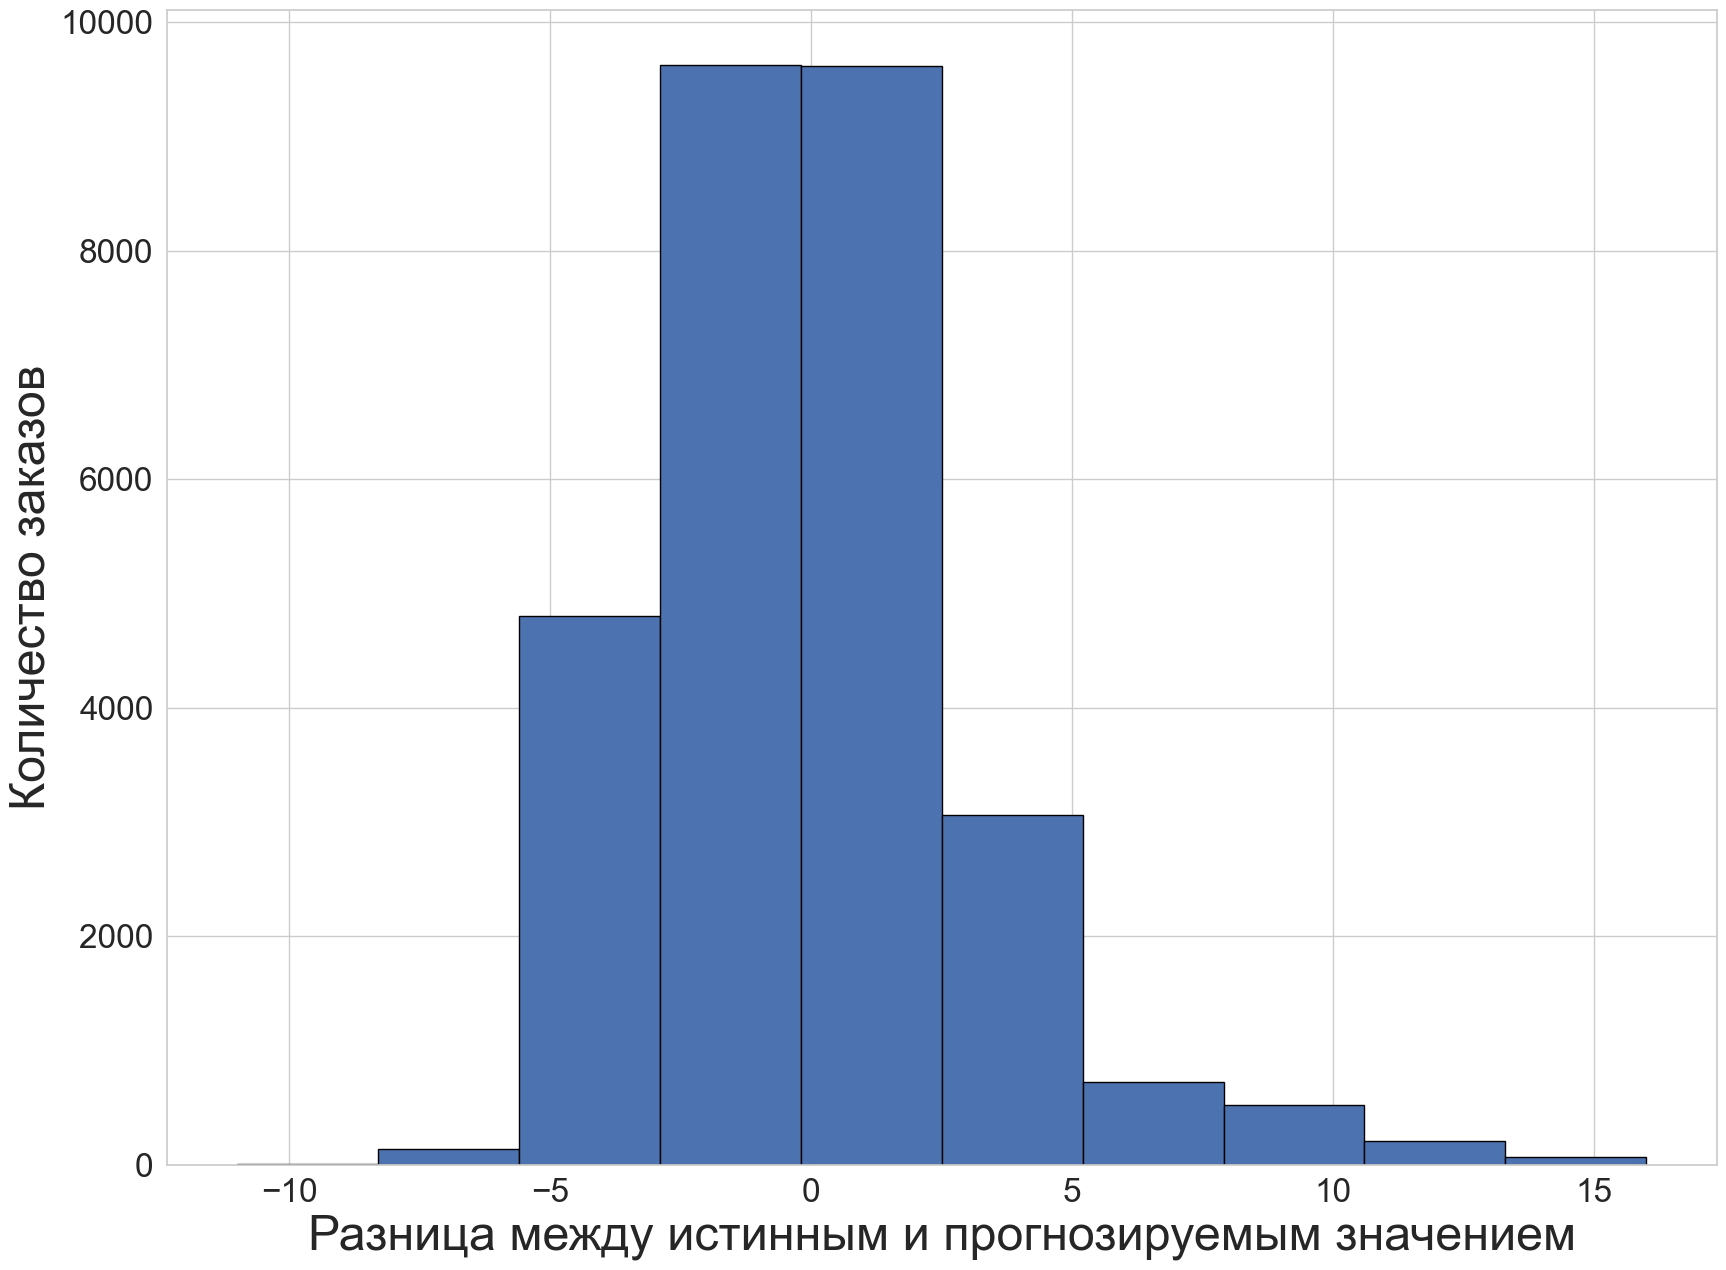

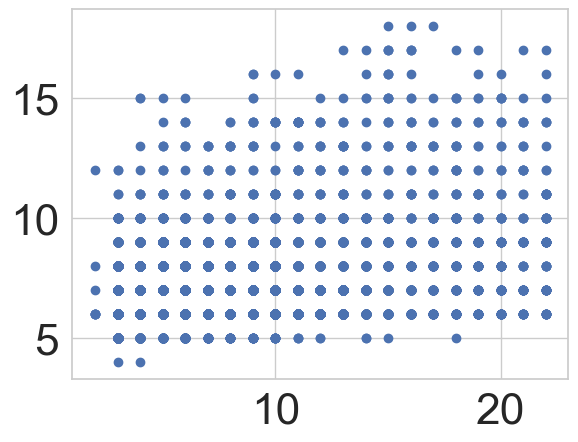

In [72]:
#выводим результаты обучения лучшей модели
show_learning_results(y_test, y_pred)